In [1]:
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
from matplotlib.colors import LogNorm
from matplotlib import rc
from numpy import inf
import os
import sys
from IPython import display


#-- this selects the first GPU
os.environ['CUDA_VISIBLE_DEVICES']="0"

from os import listdir

from pickle import dump
from pickle import load

import uproot3

import matplotlib as mpl

from datetime import datetime
import subprocess


In [2]:

import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, Dropout
from tensorflow.keras.models import Model, Sequential
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler


from tensorflow.python.client import device_lib

from pickle import dump


#has_gpu = False

has_gpu = True



from tensorflow.keras.callbacks import EarlyStopping
earlystopping = EarlyStopping(patience=20,
               verbose=True,
               restore_best_weights=True)

import os

print(tf.config.list_physical_devices())

if has_gpu :
    #os.environ['CUDA_VISIBLE_DEVICES']="0"
    physical_devices = tf.config.list_physical_devices('GPU') 
    tf.config.experimental.set_memory_growth(physical_devices[0], True)


    print("\n\n printing physical devbices from tf.config.list_physical_devices\n\n")
    print(physical_devices)

    devices = device_lib.list_local_devices()

    print("\n\n printing devices from device_lib.list_local_devices\n\n")
    print(devices)


[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'), PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


 printing physical devbices from tf.config.list_physical_devices


[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


 printing devices from device_lib.list_local_devices


[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 2483071560346386756
xla_global_id: -1
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 23084400640
locality {
  bus_id: 1
  links {
  }
}
incarnation: 15829754494308417880
physical_device_desc: "device: 0, name: NVIDIA GeForce RTX 3090, pci bus id: 0000:41:00.0, compute capability: 8.6"
xla_global_id: 416903419
]


2023-07-05 09:35:15.818097: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-07-05 09:35:15.836222: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-07-05 09:35:15.836467: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-07-05 09:35:15.839291: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-07-05 09:35:15.839482: I tensorflow/compiler/xla/stream_executo

In [3]:


training_name = 'version4b-lambda1.00-no-weights'

testmode = False
#testmode = True

#run_training = True
run_training = False


#use_weights = True
use_weights = False

if run_training :
    
    try:
        os.mkdir( '%s-training-output' % training_name )
    except:
        print('\n  Dir %s-training-output already exists\n\n' % training_name )
        print('\n\n HALTING EXECUTION \n\n')
        sys.exit()

        

#--- Hyperparameter settings.


    
#-- settings for nominal running
#max_events =   120000
#max_events =   300000
#max_events =   600000
#max_events =  1000000
max_events =  3000000
#max_events = 15000000
#max_events = 1e9
learning_rate_setval = 5e-5
batch_size_setval = 512
max_epochs = 5000
amsgrad_setval = False
patience_setval = 40
hp_lambda = 1.0

if testmode :

#-- settings for quick syntax checking runthrough
    max_events =   300000
    learning_rate_setval = 1e-3
    batch_size_setval = 4096
    max_epochs = 200





#input_file_rapgap = '/data/owen/DIS-reco/h1-2021-10-14-v5a/all-h1-rapgap.root'
#input_file_django = '/data/owen/DIS-reco/h1-2021-10-14-v5a/all-h1-django.root'

#input_file_rapgap = '/data/owen/DIS-reco/h1-2023-06-23-v6c/test-rapgap.root'
#input_file_django = '/data/owen/DIS-reco/h1-2023-06-23-v6c/test-django.root'

input_file_rapgap = '/data/owen/DIS-reco/h1-2023-06-23-v6c/all-h1-rapgap.root'
input_file_django = '/data/owen/DIS-reco/h1-2023-06-23-v6c/all-h1-django.root'


output_dir = '%s-training-output' % training_name

parfile_name = '%s/setup.txt' % output_dir

if run_training :

    parfile = open( parfile_name,'w')

    parfile.write('%s\n' % datetime.now() )
    parfile.write('training_name : %s\n' % training_name )
    parfile.write('hp_lambda : %s\n' % hp_lambda )
    parfile.write('input_file_rapgap : %s\n' % input_file_rapgap )
    parfile.write('input_file_django : %s\n' % input_file_django )
    parfile.write('max_events : %d\n' % max_events )
    parfile.write('learning_rate_setval_reg : %g\n' % learning_rate_setval )
    parfile.write('batch_size_setval : %d\n' % batch_size_setval )
    parfile.write('max_epochs : %d\n' % max_epochs )
    parfile.write('amsgrad_setval : %g\n' % amsgrad_setval )
    parfile.write('patience_setval : %g\n' % patience_setval )
    parfile.write('use_weights : %d\n' % use_weights )

    parfile.close()

print('\n\n--- Training parameters file: %s\n' % parfile_name )
print( subprocess.getoutput('cat %s' % parfile_name ) )
print('\n\n')



--- Training parameters file: version4b-lambda1.00-no-weights-training-output/setup.txt

2023-07-01 13:08:43.066975
training_name : version4b-lambda1.00-no-weights
hp_lambda : 1.0
input_file_rapgap : /data/owen/DIS-reco/h1-2023-06-23-v6c/all-h1-rapgap.root
input_file_django : /data/owen/DIS-reco/h1-2023-06-23-v6c/all-h1-django.root
max_events : 3000000
learning_rate_setval_reg : 5e-05
batch_size_setval : 512
max_epochs : 5000
amsgrad_setval : 0
patience_setval : 40
use_weights : 0





In [4]:
%%time


ur_file_rapgap = uproot3.open(input_file_rapgap)

print (ur_file_rapgap.keys()) 
ur_tree_rapgap = ur_file_rapgap['Rapgap/minitree']
print(ur_tree_rapgap)
ur_tree_rapgap.show()


#pandas_df   =  ur_tree.pandas.df(['*'], entrystop=max_events,flatten=True)

pandas_df_rapgap   =  ur_tree_rapgap.pandas.df(
    ['has_isr','has_fsr',
     'tower_sum_40','n_towers_40', 
     'eta_pho_closest_to_ebeam','e_pho_closest_to_ebeam', 'phi_pho_closest_to_ebeam',
     'obs_x', 'obs_y', 'obs_Q2',
     'from_tlv_gen_Q2','from_tlv_gen_x','from_tlv_gen_y',
     'obs_e_e','obs_e_pz','obs_e_pt','obs_e_phi',
     'obs_hfs_e','obs_hfs_pz','obs_hfs_pt','obs_hfs_phi',
     'obs_dphi',
     'Empz', 'obs_e_trk_e',
     'beam_e_e', 'wgt',
     'gen_e_e', 'gen_e_pz', 'gen_e_pt', 'gen_e_eta', 'gen_e_phi',
     'obs_e_eta',
     'gen_hfs_e', 'gen_hfs_pz', 'gen_hfs_pt', 'gen_hfs_eta',
     'gen_hfs_etacut_e','gen_hfs_etacut_pz','gen_hfs_etacut_pt','gen_hfs_etacut_eta', 'gen_hfs_etacut_phi',
     'obs_hfs_eta',
    ],
    entrystop=max_events,flatten=True)

print('\n\n Number of entries in pandas_df:  %d ' % pandas_df_rapgap.shape[0] )

[b'Rapgap;1']
<TTree b'minitree' at 0x7f0d661cbb80>
wgt                        (no streamer)              asdtype('>f4')
Empz                       (no streamer)              asdtype('>f4')
from_tlv_gen_Q2            (no streamer)              asdtype('>f4')
from_tlv_gen_x             (no streamer)              asdtype('>f4')
from_tlv_gen_y             (no streamer)              asdtype('>f4')
beam_e_e                   (no streamer)              asdtype('>f4')
beam_p_e                   (no streamer)              asdtype('>f4')
has_isr                    (no streamer)              asdtype('int8')
has_fsr                    (no streamer)              asdtype('int8')
gen_e_e                    (no streamer)              asdtype('>f4')
gen_e_pz                   (no streamer)              asdtype('>f4')
gen_e_pt                   (no streamer)              asdtype('>f4')
gen_e_phi                  (no streamer)              asdtype('>f4')
gen_e_eta                  (no streamer)         

In [5]:
%%time


ur_file_django = uproot3.open(input_file_django)

print (ur_file_django.keys()) 
ur_tree_django = ur_file_django['Django/minitree']
print(ur_tree_django)
ur_tree_django.show()


#pandas_df   =  ur_tree.pandas.df(['*'], entrystop=max_events,flatten=True)

pandas_df_django   =  ur_tree_django.pandas.df(
    ['has_isr','has_fsr',
     'tower_sum_40','n_towers_40', 
     'eta_pho_closest_to_ebeam','e_pho_closest_to_ebeam', 'phi_pho_closest_to_ebeam',
     'obs_x', 'obs_y', 'obs_Q2',
     'from_tlv_gen_Q2','from_tlv_gen_x','from_tlv_gen_y',
     'obs_e_e','obs_e_pz','obs_e_pt','obs_e_phi',
     'obs_hfs_e','obs_hfs_pz','obs_hfs_pt','obs_hfs_phi',
     'obs_dphi',
     'Empz', 'obs_e_trk_e',
     'beam_e_e', 'wgt',
     'gen_e_e', 'gen_e_pz', 'gen_e_pt', 'gen_e_eta', 'gen_e_phi',
     'obs_e_eta',
     'gen_hfs_e', 'gen_hfs_pz', 'gen_hfs_pt', 'gen_hfs_eta',
     'gen_hfs_etacut_e','gen_hfs_etacut_pz','gen_hfs_etacut_pt','gen_hfs_etacut_eta', 'gen_hfs_etacut_phi',
     'obs_hfs_eta',
    ],
    entrystop=max_events,flatten=True)

print('\n\n Number of entries in pandas_df:  %d ' % pandas_df_django.shape[0] )

[b'Django;1']
<TTree b'minitree' at 0x7f0d11569bd0>
wgt                        (no streamer)              asdtype('>f4')
Empz                       (no streamer)              asdtype('>f4')
from_tlv_gen_Q2            (no streamer)              asdtype('>f4')
from_tlv_gen_x             (no streamer)              asdtype('>f4')
from_tlv_gen_y             (no streamer)              asdtype('>f4')
beam_e_e                   (no streamer)              asdtype('>f4')
beam_p_e                   (no streamer)              asdtype('>f4')
has_isr                    (no streamer)              asdtype('int8')
has_fsr                    (no streamer)              asdtype('int8')
gen_e_e                    (no streamer)              asdtype('>f4')
gen_e_pz                   (no streamer)              asdtype('>f4')
gen_e_pt                   (no streamer)              asdtype('>f4')
gen_e_phi                  (no streamer)              asdtype('>f4')
gen_e_eta                  (no streamer)         

In [6]:
pandas_df_rapgap.eval( 'obs_hfs_Empz = obs_hfs_e - obs_hfs_pz', inplace=True )
pandas_df_rapgap.eval( 'obs_e_Empz = obs_e_e - obs_e_pz', inplace=True )

pandas_df_rapgap.eval( 'obs_event_Empz = obs_hfs_Empz + obs_e_Empz', inplace=True )

pandas_df_rapgap.eval( 'rot_pt1 = 0.70710678 * obs_hfs_pt - 0.70710678 * obs_e_pt', inplace=True )
pandas_df_rapgap.eval( 'rot_pt2 = 0.70710678 * obs_hfs_pt + 0.70710678 * obs_e_pt', inplace=True )

pandas_df_rapgap.eval( 'rot_Empz1 = 0.70710678 * obs_hfs_Empz - 0.70710678 * obs_e_Empz', inplace=True )
pandas_df_rapgap.eval( 'rot_Empz2 = 0.70710678 * obs_hfs_Empz + 0.70710678 * obs_e_Empz', inplace=True )

pandas_df_rapgap.eval( 'gen_log_x = log(from_tlv_gen_x)', inplace=True )
pandas_df_rapgap.eval( 'gen_log_y = log(from_tlv_gen_y)', inplace=True )
pandas_df_rapgap.eval( 'gen_log_Q2 = log(from_tlv_gen_Q2)', inplace=True )

pandas_df_rapgap.eval( 'e_ecal_over_trk_ratio = tower_sum_40/obs_e_trk_e', inplace=True )
pandas_df_rapgap.eval( 'e_ecal_over_trk_ratio = (e_ecal_over_trk_ratio<4)*e_ecal_over_trk_ratio + (e_ecal_over_trk_ratio>4)*4', inplace=True )

pandas_df_rapgap.eval( 'dphi_pho_closest_to_ebeam = obs_e_phi - phi_pho_closest_to_ebeam', inplace=True )
pandas_df_rapgap.eval( 'dphi_pho_closest_to_ebeam = (abs(dphi_pho_closest_to_ebeam)<3.14159265)*(dphi_pho_closest_to_ebeam)+(dphi_pho_closest_to_ebeam>3.14159265)*(dphi_pho_closest_to_ebeam-2*3.14159265) + (dphi_pho_closest_to_ebeam<-3.14159265)*(dphi_pho_closest_to_ebeam+2*3.14159265)', inplace=True )
pandas_df_rapgap.eval( 'dphi_pho_closest_to_ebeam = (dphi_pho_closest_to_ebeam>0)*dphi_pho_closest_to_ebeam + (dphi_pho_closest_to_ebeam<0)*(dphi_pho_closest_to_ebeam+2*3.14159265)', inplace=True )
pandas_df_rapgap.eval( 'dphi_pho_closest_to_ebeam = (phi_pho_closest_to_ebeam!=0)*(dphi_pho_closest_to_ebeam)+(phi_pho_closest_to_ebeam==0)*(-1)', inplace=True )

pandas_df_rapgap.eval( 'e_pho_closest_to_ebeam = (e_pho_closest_to_ebeam<30)*e_pho_closest_to_ebeam + (e_pho_closest_to_ebeam>30)*30', inplace=True )

pandas_df_rapgap.eval( 'n_towers_40 = (n_towers_40<7)*n_towers_40 + (n_towers_40>=7)*7', inplace=True  )

pandas_df_rapgap.eval( 'has_norad = (has_isr==0) and (has_fsr==0)', inplace=True )

In [7]:
pandas_df_django.eval( 'obs_hfs_Empz = obs_hfs_e - obs_hfs_pz', inplace=True )
pandas_df_django.eval( 'obs_e_Empz = obs_e_e - obs_e_pz', inplace=True )

pandas_df_django.eval( 'obs_event_Empz = obs_hfs_Empz + obs_e_Empz', inplace=True )

pandas_df_django.eval( 'rot_pt1 = 0.70710678 * obs_hfs_pt - 0.70710678 * obs_e_pt', inplace=True )
pandas_df_django.eval( 'rot_pt2 = 0.70710678 * obs_hfs_pt + 0.70710678 * obs_e_pt', inplace=True )

pandas_df_django.eval( 'rot_Empz1 = 0.70710678 * obs_hfs_Empz - 0.70710678 * obs_e_Empz', inplace=True )
pandas_df_django.eval( 'rot_Empz2 = 0.70710678 * obs_hfs_Empz + 0.70710678 * obs_e_Empz', inplace=True )

pandas_df_django.eval( 'gen_log_x = log(from_tlv_gen_x)', inplace=True )
pandas_df_django.eval( 'gen_log_y = log(from_tlv_gen_y)', inplace=True )
pandas_df_django.eval( 'gen_log_Q2 = log(from_tlv_gen_Q2)', inplace=True )

pandas_df_django.eval( 'e_ecal_over_trk_ratio = tower_sum_40/obs_e_trk_e', inplace=True )
pandas_df_django.eval( 'e_ecal_over_trk_ratio = (e_ecal_over_trk_ratio<4)*e_ecal_over_trk_ratio + (e_ecal_over_trk_ratio>4)*4', inplace=True )

pandas_df_django.eval( 'dphi_pho_closest_to_ebeam = obs_e_phi - phi_pho_closest_to_ebeam', inplace=True )
pandas_df_django.eval( 'dphi_pho_closest_to_ebeam = (abs(dphi_pho_closest_to_ebeam)<3.14159265)*(dphi_pho_closest_to_ebeam)+(dphi_pho_closest_to_ebeam>3.14159265)*(dphi_pho_closest_to_ebeam-2*3.14159265) + (dphi_pho_closest_to_ebeam<-3.14159265)*(dphi_pho_closest_to_ebeam+2*3.14159265)', inplace=True )
pandas_df_django.eval( 'dphi_pho_closest_to_ebeam = (dphi_pho_closest_to_ebeam>0)*dphi_pho_closest_to_ebeam + (dphi_pho_closest_to_ebeam<0)*(dphi_pho_closest_to_ebeam+2*3.14159265)', inplace=True )
pandas_df_django.eval( 'dphi_pho_closest_to_ebeam = (phi_pho_closest_to_ebeam!=0)*(dphi_pho_closest_to_ebeam)+(phi_pho_closest_to_ebeam==0)*(-1)', inplace=True )

pandas_df_django.eval( 'e_pho_closest_to_ebeam = (e_pho_closest_to_ebeam<30)*e_pho_closest_to_ebeam + (e_pho_closest_to_ebeam>30)*30', inplace=True )

pandas_df_django.eval( 'n_towers_40 = (n_towers_40<7)*n_towers_40 + (n_towers_40>=7)*7', inplace=True  )

pandas_df_django.eval( 'has_norad = (has_isr==0) and (has_fsr==0)', inplace=True )

In [8]:


pandas_df_rapgap.eval( 'obs_ptbal = 1. - obs_e_pt / obs_hfs_pt', inplace=True )
pandas_df_rapgap.eval( 'obs_pzbal = 1. - (obs_hfs_Empz + obs_e_Empz)/2./beam_e_e', inplace=True )



In [9]:


pandas_df_django.eval( 'obs_ptbal = 1. - obs_e_pt / obs_hfs_pt', inplace=True )
pandas_df_django.eval( 'obs_pzbal = 1. - (obs_hfs_Empz + obs_e_Empz)/2./beam_e_e', inplace=True )



In [10]:
pandas_df_rapgap.eval( 'gen_dphi_etacut = (gen_e_phi - gen_hfs_etacut_phi) + ((gen_e_phi - gen_hfs_etacut_phi)<0)*2*3.14159 - ((gen_e_phi - gen_hfs_etacut_phi)>2*3.14159)*2*3.14159', inplace=True )

In [11]:
pandas_df_django.eval( 'gen_dphi_etacut = (gen_e_phi - gen_hfs_etacut_phi) + ((gen_e_phi - gen_hfs_etacut_phi)<0)*2*3.14159 - ((gen_e_phi - gen_hfs_etacut_phi)>2*3.14159)*2*3.14159', inplace=True )

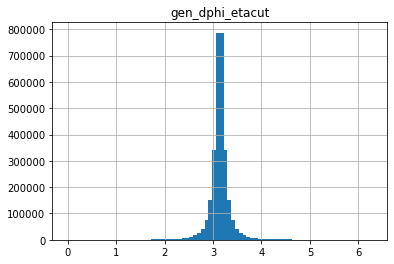

In [12]:
pandas_df_django.hist( column=['gen_dphi_etacut'], bins=80)
plt.show()

## Apply any event selection here.

In [13]:
pandas_df_rapgap = pandas_df_rapgap.query('Empz > 0')

pandas_df_rapgap = pandas_df_rapgap.query('obs_event_Empz > 46 and obs_event_Empz < 62')

pandas_df_rapgap = pandas_df_rapgap.query('obs_hfs_pt > 0')

pandas_df_rapgap = pandas_df_rapgap.query('from_tlv_gen_Q2 > 200')

pandas_df_rapgap = pandas_df_rapgap.query('e_ecal_over_trk_ratio > 0')

#-- 2023-06-23 : remove small fraction of events that have gen_hfs_etacut_e = 0

pandas_df_rapgap = pandas_df_rapgap.query('gen_hfs_etacut_e > 0')

print('\n\n Number of entries in pandas_df_rapgap:  %d ' % pandas_df_rapgap.shape[0] )



 Number of entries in pandas_df_rapgap:  613773 


In [14]:
pandas_df_django = pandas_df_django.query('Empz > 0')

pandas_df_django = pandas_df_django.query('obs_event_Empz > 46 and obs_event_Empz < 62')

pandas_df_django = pandas_df_django.query('obs_hfs_pt > 0')

pandas_df_django = pandas_df_django.query('from_tlv_gen_Q2 > 200')

pandas_df_django = pandas_df_django.query('e_ecal_over_trk_ratio > 0')

#-- 2023-06-23 : remove small fraction of events that have gen_hfs_etacut_e = 0

pandas_df_django = pandas_df_django.query('gen_hfs_etacut_e > 0')

print('\n\n Number of entries in pandas_df_django:  %d ' % pandas_df_django.shape[0] )



 Number of entries in pandas_df_django:  564057 


In [15]:
pandas_df_rapgap

,has_isr,has_fsr,tower_sum_40,n_towers_40,eta_pho_closest_to_ebeam,e_pho_closest_to_ebeam,phi_pho_closest_to_ebeam,obs_x[0],obs_x[1],obs_x[2],...,rot_Empz2,gen_log_x,gen_log_y,gen_log_Q2,e_ecal_over_trk_ratio,dphi_pho_closest_to_ebeam,has_norad,obs_ptbal,obs_pzbal,gen_dphi_etacut
entry,,,,,,,,,,,,,,,,,,,,,
23,0,0,24.247692,1,-0.182699,0.144760,2.422777,0.015283,0.019567,0.009369,...,43.001450,-4.329937,-1.276337,5.922210,1.071315,0.428013,True,0.060719,-0.101689,3.202085
36,0,1,13.348120,1,-1.709016,0.566964,-0.436204,0.003809,0.002255,0.004362,...,37.739708,-5.503805,-0.571310,5.453369,0.988650,2.755722,False,-0.035760,0.033116,3.166307
45,0,0,25.104801,1,-0.021559,1.420366,2.370969,0.013934,0.019074,0.008570,...,42.132053,-4.499992,-1.604122,5.424370,2.409008,3.302941,True,0.168212,-0.079415,3.160574
47,0,1,20.143602,1,0.018809,0.729400,-1.816074,0.007061,0.004471,0.008294,...,37.633305,-4.799874,-1.136600,5.592010,1.761387,2.691795,False,0.091957,0.035842,3.144557
56,1,0,32.968731,1,0.195189,0.114277,0.189013,0.092370,0.113946,0.127623,...,38.093636,-1.782004,-2.935359,6.801494,0.950580,3.264253,False,0.052082,0.024048,3.155321
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2999978,0,0,29.941027,1,1.322684,0.225233,-1.767398,0.044368,0.048523,0.059957,...,37.481941,-2.872268,-1.924640,6.731575,2.845239,2.932869,True,0.094121,0.039720,3.140613
2999984,0,0,25.384007,1,0.758430,0.135375,-1.940322,0.013417,0.007338,0.019171,...,37.511471,-3.935594,-2.249312,5.343578,1.021598,0.233744,True,0.047993,0.038963,3.158126
2999988,0,1,24.123011,1,-0.261212,3.840036,-0.663984,0.012221,0.015808,0.009090,...,41.129143,-4.652722,-1.352999,5.522763,4.000000,3.402529,False,-0.057863,-0.053721,3.155354


In [16]:
pandas_df_django

,has_isr,has_fsr,tower_sum_40,n_towers_40,eta_pho_closest_to_ebeam,e_pho_closest_to_ebeam,phi_pho_closest_to_ebeam,obs_x[0],obs_x[1],obs_x[2],...,rot_Empz2,gen_log_x,gen_log_y,gen_log_Q2,e_ecal_over_trk_ratio,dphi_pho_closest_to_ebeam,has_norad,obs_ptbal,obs_pzbal,gen_dphi_etacut
entry,,,,,,,,,,,,,,,,,,,,,
20,0,0,17.255196,1,-1.066193,0.240274,1.518299,0.004745,0.002059,0.005654,...,37.362167,-5.230584,-0.867193,5.430706,0.931784,2.221198,True,0.123451,0.042788,3.177054
22,0,0,29.893789,1,0.895007,0.601942,2.087080,0.052515,0.058272,0.067616,...,38.152119,-2.721840,-2.399088,6.407556,0.984936,2.996598,True,-0.094159,0.022550,3.175841
27,0,0,23.783131,1,-0.131410,0.446848,-1.933851,0.011714,0.016146,0.008042,...,41.864983,-4.471905,-1.468582,5.587996,1.080399,2.321987,True,0.317030,-0.072573,3.076885
33,1,0,24.646885,1,1.005825,0.120665,0.242550,0.015225,0.018389,0.011058,...,41.343658,-4.208622,-1.516757,5.799310,1.080347,1.063548,False,0.240941,-0.059217,3.212621
38,0,0,12.380091,1,-2.888133,1.764309,-0.540577,0.003480,0.003441,0.003494,...,38.996613,-5.732018,-0.448362,5.348104,0.986371,3.510371,True,-0.131654,0.000914,3.076051
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2999970,1,0,21.685556,1,-2.256334,8.394147,2.447153,0.008636,0.009761,0.007985,...,39.685410,-1.904118,-3.819149,5.458082,1.049069,6.162529,False,-0.692709,-0.016733,3.082457
2999975,0,0,23.934727,1,0.277469,0.352661,1.015150,0.010451,0.008657,0.011655,...,38.363922,-4.495461,-1.628446,5.404577,0.980746,3.396799,True,-0.041800,0.017124,3.163761
2999981,0,1,53.966328,1,2.628084,0.729838,2.014559,0.310944,0.592958,0.658529,...,37.037674,-0.519238,-2.862104,8.147141,1.068173,2.003499,False,-0.084287,0.051102,3.139594


## Comparison of gen x, y, Q2

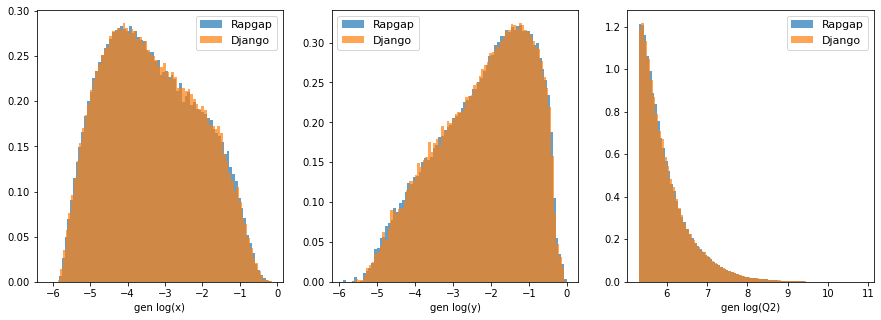

In [17]:
fig,ax = plt.subplots(1,3,figsize=(15,5))

hbins=80
halpha=0.7

ax[0].hist( pandas_df_rapgap['gen_log_x'], weights=pandas_df_rapgap['wgt'], label='Rapgap', density=True, bins=hbins, alpha=halpha )
ax[0].hist( pandas_df_django['gen_log_x'], weights=pandas_df_django['wgt'], label='Django', density=True, bins=hbins, alpha=halpha )

ax[1].hist( pandas_df_rapgap['gen_log_y'], weights=pandas_df_rapgap['wgt'], label='Rapgap', density=True, bins=hbins, alpha=halpha )
ax[1].hist( pandas_df_django['gen_log_y'], weights=pandas_df_django['wgt'], label='Django', density=True, bins=hbins, alpha=halpha )

ax[2].hist( pandas_df_rapgap['gen_log_Q2'], weights=pandas_df_rapgap['wgt'], label='Rapgap', density=True, bins=hbins, alpha=halpha )
ax[2].hist( pandas_df_django['gen_log_Q2'], weights=pandas_df_django['wgt'], label='Django', density=True, bins=hbins, alpha=halpha )


ax[0].set_xlabel('gen log(x)')
ax[1].set_xlabel('gen log(y)')
ax[2].set_xlabel('gen log(Q2)')

ax[0].legend( loc='best', fontsize=11)
ax[1].legend( loc='best', fontsize=11)
ax[2].legend( loc='best', fontsize=11)

plt.show()

## Comparison of Rapgap and Django

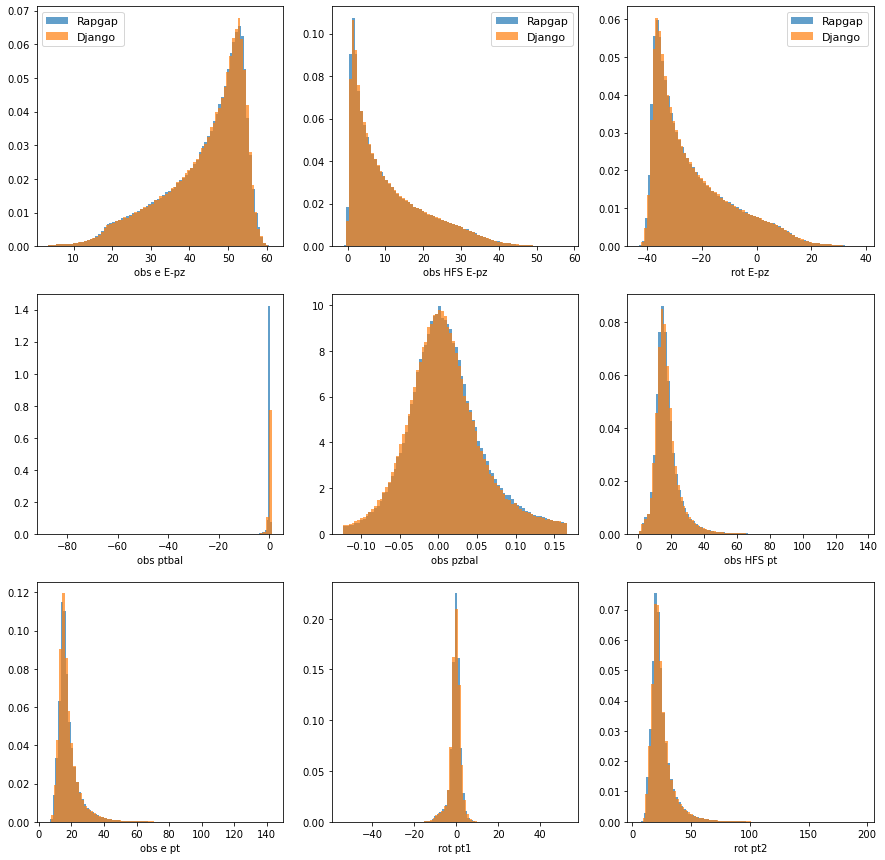

In [18]:
fig,ax = plt.subplots(3,3,figsize=(15,15))

hbins=80
halpha=0.7




ax[0][0].hist( pandas_df_rapgap['obs_e_Empz'], weights=pandas_df_rapgap['wgt'], label='Rapgap', density=True, bins=hbins, alpha=halpha )
ax[0][0].hist( pandas_df_django['obs_e_Empz'], weights=pandas_df_django['wgt'], label='Django', density=True, bins=hbins, alpha=halpha )

ax[0][1].hist( pandas_df_rapgap['obs_hfs_Empz'], weights=pandas_df_rapgap['wgt'], label='Rapgap', density=True, bins=hbins, alpha=halpha )
ax[0][1].hist( pandas_df_django['obs_hfs_Empz'], weights=pandas_df_django['wgt'], label='Django', density=True, bins=hbins, alpha=halpha )

ax[0][2].hist( pandas_df_rapgap['rot_Empz1'], weights=pandas_df_rapgap['wgt'], label='Rapgap', density=True, bins=hbins, alpha=halpha )
ax[0][2].hist( pandas_df_django['rot_Empz1'], weights=pandas_df_django['wgt'], label='Django', density=True, bins=hbins, alpha=halpha )




ax[1][0].hist( pandas_df_rapgap['obs_ptbal'], weights=pandas_df_rapgap['wgt'], label='Rapgap', density=True, bins=hbins, alpha=halpha )
ax[1][0].hist( pandas_df_django['obs_ptbal'], weights=pandas_df_django['wgt'], label='Django', density=True, bins=hbins, alpha=halpha )

ax[1][1].hist( pandas_df_rapgap['obs_pzbal'], weights=pandas_df_rapgap['wgt'], label='Rapgap', density=True, bins=hbins, alpha=halpha )
ax[1][1].hist( pandas_df_django['obs_pzbal'], weights=pandas_df_django['wgt'], label='Django', density=True, bins=hbins, alpha=halpha )

ax[1][2].hist( pandas_df_rapgap['obs_hfs_pt'], weights=pandas_df_rapgap['wgt'], label='Rapgap', density=True, bins=hbins, alpha=halpha )
ax[1][2].hist( pandas_df_django['obs_hfs_pt'], weights=pandas_df_django['wgt'], label='Django', density=True, bins=hbins, alpha=halpha )






ax[2][0].hist( pandas_df_rapgap['obs_e_pt'], weights=pandas_df_rapgap['wgt'], label='Rapgap', density=True, bins=hbins, alpha=halpha )
ax[2][0].hist( pandas_df_django['obs_e_pt'], weights=pandas_df_django['wgt'], label='Django', density=True, bins=hbins, alpha=halpha )

ax[2][1].hist( pandas_df_rapgap['rot_pt1'], weights=pandas_df_rapgap['wgt'], label='Rapgap', density=True, bins=hbins, alpha=halpha )
ax[2][1].hist( pandas_df_django['rot_pt1'], weights=pandas_df_django['wgt'], label='Django', density=True, bins=hbins, alpha=halpha )

ax[2][2].hist( pandas_df_rapgap['rot_pt2'], weights=pandas_df_rapgap['wgt'], label='Rapgap', density=True, bins=hbins, alpha=halpha )
ax[2][2].hist( pandas_df_django['rot_pt2'], weights=pandas_df_django['wgt'], label='Django', density=True, bins=hbins, alpha=halpha )







ax[0][0].set_xlabel('obs e E-pz')
ax[0][1].set_xlabel('obs HFS E-pz')
ax[0][2].set_xlabel('rot E-pz')

ax[1][0].set_xlabel('obs ptbal')
ax[1][1].set_xlabel('obs pzbal')
ax[1][2].set_xlabel('obs HFS pt')

ax[2][0].set_xlabel('obs e pt')
ax[2][1].set_xlabel('rot pt1')
ax[2][2].set_xlabel('rot pt2')




ax[0][0].legend( loc='best', fontsize=11)
ax[0][1].legend( loc='best', fontsize=11)
ax[0][2].legend( loc='best', fontsize=11)

plt.show()

## Rapgap, comparison of detector and particle (obs and gen)

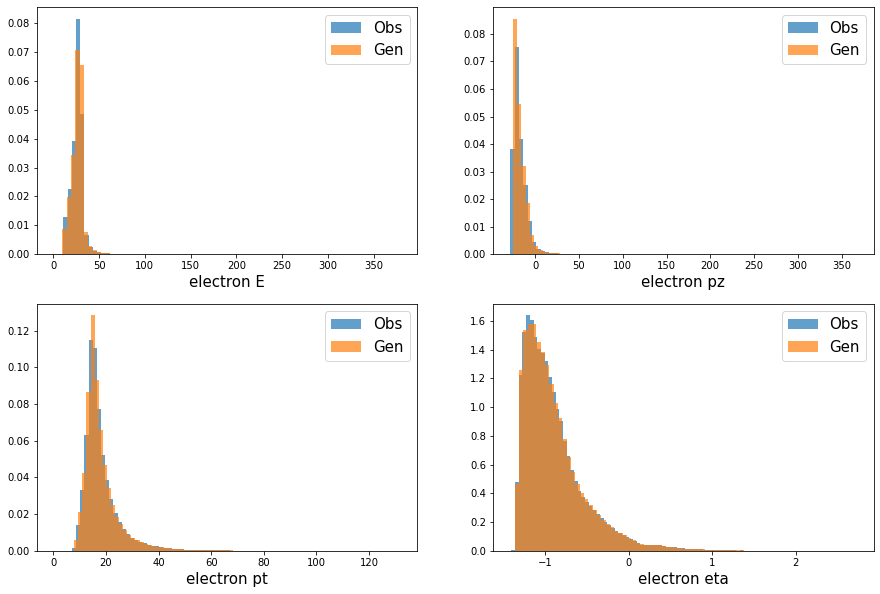

In [19]:
fig,ax = plt.subplots(2,2,figsize=(15,10))

hbins=80
halpha=0.7




ax[0][0].hist( pandas_df_rapgap['obs_e_e'], weights=pandas_df_rapgap['wgt'], label='Obs', density=True, bins=hbins, alpha=halpha )
ax[0][0].hist( pandas_df_rapgap['gen_e_e'], weights=pandas_df_rapgap['wgt'], label='Gen', density=True, bins=hbins, alpha=halpha )

ax[0][1].hist( pandas_df_rapgap['obs_e_pz'], weights=pandas_df_rapgap['wgt'], label='Obs', density=True, bins=hbins, alpha=halpha )
ax[0][1].hist( pandas_df_rapgap['gen_e_pz'], weights=pandas_df_rapgap['wgt'], label='Gen', density=True, bins=hbins, alpha=halpha )

ax[1][0].hist( pandas_df_rapgap['obs_e_pt'], weights=pandas_df_rapgap['wgt'], label='Obs', density=True, bins=hbins, alpha=halpha )
ax[1][0].hist( pandas_df_rapgap['gen_e_pt'], weights=pandas_df_rapgap['wgt'], label='Gen', density=True, bins=hbins, alpha=halpha )

ax[1][1].hist( pandas_df_rapgap['obs_e_eta'], weights=pandas_df_rapgap['wgt'], label='Obs', density=True, bins=hbins, alpha=halpha )
ax[1][1].hist( pandas_df_rapgap['gen_e_eta'], weights=pandas_df_rapgap['wgt'], label='Gen', density=True, bins=hbins, alpha=halpha )


hfontsize=15

ax[0][0].set_xlabel('electron E', fontsize=hfontsize)
ax[0][1].set_xlabel('electron pz', fontsize=hfontsize)

ax[1][0].set_xlabel('electron pt', fontsize=hfontsize)
ax[1][1].set_xlabel('electron eta', fontsize=hfontsize)

ax[0][0].legend( loc='best', fontsize=hfontsize)
ax[0][1].legend( loc='best', fontsize=hfontsize)

ax[1][0].legend( loc='best', fontsize=hfontsize)
ax[1][1].legend( loc='best', fontsize=hfontsize)





plt.show()

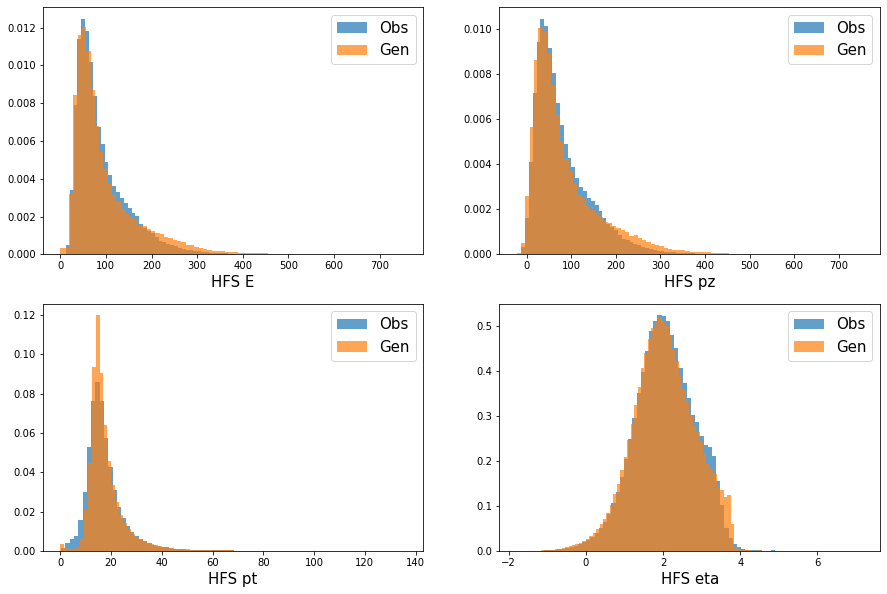

In [20]:
fig,ax = plt.subplots(2,2,figsize=(15,10))

hbins=80
halpha=0.7




ax[0][0].hist( pandas_df_rapgap['obs_hfs_e'], weights=pandas_df_rapgap['wgt'], label='Obs', density=True, bins=hbins, alpha=halpha )
ax[0][0].hist( pandas_df_rapgap['gen_hfs_etacut_e'], weights=pandas_df_rapgap['wgt'], label='Gen', density=True, bins=hbins, alpha=halpha )

ax[0][1].hist( pandas_df_rapgap['obs_hfs_pz'], weights=pandas_df_rapgap['wgt'], label='Obs', density=True, bins=hbins, alpha=halpha )
ax[0][1].hist( pandas_df_rapgap['gen_hfs_etacut_pz'], weights=pandas_df_rapgap['wgt'], label='Gen', density=True, bins=hbins, alpha=halpha )

ax[1][0].hist( pandas_df_rapgap['obs_hfs_pt'], weights=pandas_df_rapgap['wgt'], label='Obs', density=True, bins=hbins, alpha=halpha )
ax[1][0].hist( pandas_df_rapgap['gen_hfs_etacut_pt'], weights=pandas_df_rapgap['wgt'], label='Gen', density=True, bins=hbins, alpha=halpha )

ax[1][1].hist( pandas_df_rapgap['obs_hfs_eta'], weights=pandas_df_rapgap['wgt'], label='Obs', density=True, bins=hbins, alpha=halpha )
ax[1][1].hist( pandas_df_rapgap['gen_hfs_etacut_eta'], weights=pandas_df_rapgap['wgt'], label='Gen', density=True, bins=hbins, alpha=halpha )

hfontsize=15

ax[0][0].set_xlabel('HFS E', fontsize=hfontsize)
ax[0][1].set_xlabel('HFS pz', fontsize=hfontsize)

ax[1][0].set_xlabel('HFS pt', fontsize=hfontsize)
ax[1][1].set_xlabel('HFS eta', fontsize=hfontsize)

ax[0][0].legend( loc='best', fontsize=hfontsize)
ax[0][1].legend( loc='best', fontsize=hfontsize)

ax[1][0].legend( loc='best', fontsize=hfontsize)
ax[1][1].legend( loc='best', fontsize=hfontsize)



plt.show()

## Look at the distribution of event weights.

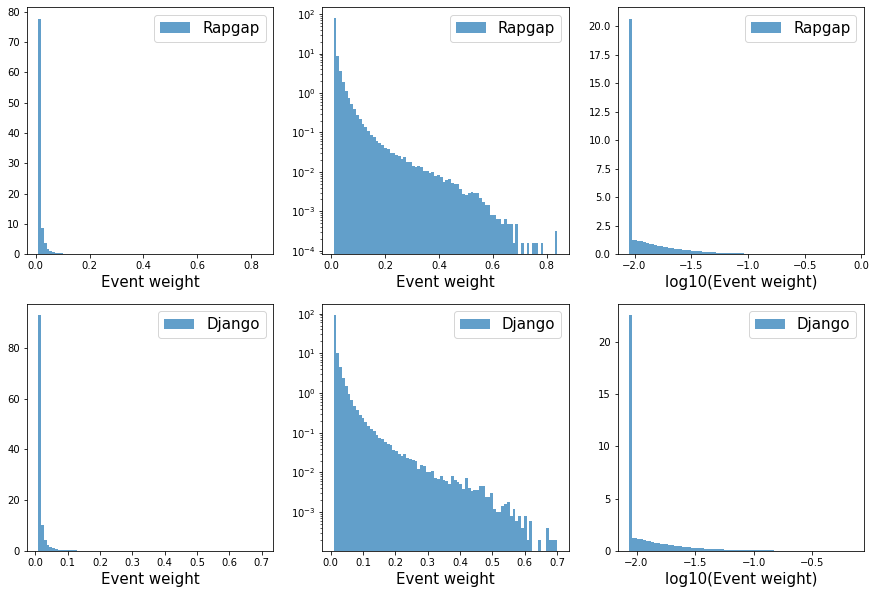

In [21]:
fig,ax = plt.subplots(2,3,figsize=(15,10))

ax[0][0].hist( pandas_df_rapgap['wgt'], density=True, bins=hbins, alpha=halpha, label='Rapgap' )
ax[0][1].hist( pandas_df_rapgap['wgt'], density=True, bins=hbins, alpha=halpha, label='Rapgap' )
ax[0][2].hist( np.log10(pandas_df_rapgap['wgt']), density=True, bins=hbins, alpha=halpha, label='Rapgap' )

#ax[0][2].hist( np.log10(pandas_df_rapgap.query('wgt>0.01')['wgt']), density=True, bins=hbins, alpha=halpha, label='Rapgap' )



ax[1][0].hist( pandas_df_django['wgt'], density=True, bins=hbins, alpha=halpha, label='Django' )
ax[1][1].hist( pandas_df_django['wgt'], density=True, bins=hbins, alpha=halpha, label='Django' )
ax[1][2].hist( np.log10(pandas_df_django['wgt']), density=True, bins=hbins, alpha=halpha, label='Django' )

#ax[1][2].hist( np.log10(pandas_df_django.query('wgt>0.01')['wgt']), density=True, bins=hbins, alpha=halpha, label='Django' )



ax[0][1].set_yscale('log')
ax[1][1].set_yscale('log')

hfontsize=15

ax[0][0].legend( loc='best', fontsize=hfontsize )
ax[1][0].legend( loc='best', fontsize=hfontsize )

ax[0][1].legend( loc='best', fontsize=hfontsize )
ax[1][1].legend( loc='best', fontsize=hfontsize )

ax[0][2].legend( loc='best', fontsize=hfontsize )
ax[1][2].legend( loc='best', fontsize=hfontsize )


ax[0][0].set_xlabel('Event weight', fontsize=hfontsize)
ax[0][1].set_xlabel('Event weight', fontsize=hfontsize)
ax[0][2].set_xlabel('log10(Event weight)', fontsize=hfontsize)

ax[1][0].set_xlabel('Event weight', fontsize=hfontsize)
ax[1][1].set_xlabel('Event weight', fontsize=hfontsize)
ax[1][2].set_xlabel('log10(Event weight)', fontsize=hfontsize)


plt.show()

## Set up machine learning stuff

In [22]:
X_gen_r = np.c_[
    pandas_df_rapgap['gen_e_e'].to_numpy(),
    pandas_df_rapgap['gen_e_pz'].to_numpy(),
    pandas_df_rapgap['gen_e_pt'].to_numpy(),
    pandas_df_rapgap['gen_e_eta'].to_numpy(),
    pandas_df_rapgap['gen_hfs_etacut_e'].to_numpy(),
    pandas_df_rapgap['gen_hfs_etacut_pz'].to_numpy(),
    pandas_df_rapgap['gen_hfs_etacut_pt'].to_numpy(),
    pandas_df_rapgap['gen_hfs_etacut_eta'].to_numpy(),
    pandas_df_rapgap['gen_dphi_etacut'].to_numpy(),
]

X_obs_r = np.c_[
    pandas_df_rapgap['obs_e_e'].to_numpy(),
    pandas_df_rapgap['obs_e_pz'].to_numpy(),
    pandas_df_rapgap['obs_e_pt'].to_numpy(),
    pandas_df_rapgap['obs_e_eta'].to_numpy(),
    pandas_df_rapgap['obs_hfs_e'].to_numpy(),
    pandas_df_rapgap['obs_hfs_pz'].to_numpy(),
    pandas_df_rapgap['obs_hfs_pt'].to_numpy(),
    pandas_df_rapgap['obs_hfs_eta'].to_numpy(),
    pandas_df_rapgap['obs_dphi'].to_numpy(),
]


w_r = np.c_[
    pandas_df_rapgap['wgt'].to_numpy(),
]

Y_r = np.c_[
    np.ones(len(pandas_df_rapgap))
]

In [23]:
print(" shapes:  X_gen_r = %s , X_obs_r = %s , w_r = %s , Y_r = %s" % ( str(np.shape(X_gen_r)), str(np.shape(X_obs_r)), str(np.shape(w_r)), str(np.shape(Y_r)) ) )


 shapes:  X_gen_r = (613773, 9) , X_obs_r = (613773, 9) , w_r = (613773, 1) , Y_r = (613773, 1)


In [24]:
X_gen_d = np.c_[
    pandas_df_django['gen_e_e'].to_numpy(),
    pandas_df_django['gen_e_pz'].to_numpy(),
    pandas_df_django['gen_e_pt'].to_numpy(),
    pandas_df_django['gen_e_eta'].to_numpy(),
    pandas_df_django['gen_hfs_etacut_e'].to_numpy(),
    pandas_df_django['gen_hfs_etacut_pz'].to_numpy(),
    pandas_df_django['gen_hfs_etacut_pt'].to_numpy(),
    pandas_df_django['gen_hfs_etacut_eta'].to_numpy(),
    pandas_df_django['gen_dphi_etacut'].to_numpy(),
]

X_obs_d = np.c_[
    pandas_df_django['obs_e_e'].to_numpy(),
    pandas_df_django['obs_e_pz'].to_numpy(),
    pandas_df_django['obs_e_pt'].to_numpy(),
    pandas_df_django['obs_e_eta'].to_numpy(),
    pandas_df_django['obs_hfs_e'].to_numpy(),
    pandas_df_django['obs_hfs_pz'].to_numpy(),
    pandas_df_django['obs_hfs_pt'].to_numpy(),
    pandas_df_django['obs_hfs_eta'].to_numpy(),
    pandas_df_django['obs_dphi'].to_numpy(),
]




w_d = np.c_[
    pandas_df_django['wgt'].to_numpy(),
]

Y_d = np.c_[
    np.zeros(len(pandas_df_django))
]


In [25]:
print(" shapes:  X_gen_d = %s , X_obs_d = %s , w_d = %s , Y_d = %s" % ( str(np.shape(X_gen_d)), str(np.shape(X_obs_d)), str(np.shape(w_d)), str(np.shape(Y_d)) ) )

 shapes:  X_gen_d = (564057, 9) , X_obs_d = (564057, 9) , w_d = (564057, 1) , Y_d = (564057, 1)


In [26]:
X_gen = np.concatenate( [X_gen_r, X_gen_d] )
X_obs = np.concatenate( [X_obs_r, X_obs_d] )
w = np.concatenate( [w_r, w_d])
Y = np.concatenate( [Y_r, Y_d])

In [27]:
print(" shapes:  X_gen = %s , X_obs = %s ,  w = %s , Y = %s" % ( str(np.shape(X_gen)),  str(np.shape(X_obs)), str(np.shape(w)), str(np.shape(Y)) ) )

 shapes:  X_gen = (1177830, 9) , X_obs = (1177830, 9) ,  w = (1177830, 1) , Y = (1177830, 1)


In [28]:
X_gen

array([[ 23.27876663, -16.51725578,  16.40369606, ...,  16.67554092,
          1.93788922,   3.20208526],
       [ 13.49057484,  -9.36167717,   9.71362972, ...,   9.75612164,
          2.02149129,   3.16630697],
       [ 24.10554504, -19.99560928,  13.46301937, ...,  13.40249443,
          1.97886217,   3.16057396],
       ...,
       [ 57.31091309,   5.26610613,  57.06845856, ...,  56.59249878,
          2.95949411,   3.13959432],
       [ 18.31459999,  -7.90270472,  16.52186012, ...,  16.62121964,
          1.2708863 ,   3.09988546],
       [ 23.50551033, -15.97074509,  17.2465744 , ...,  18.2353096 ,
          1.8383379 ,   3.1121409 ]])

In [29]:
X_obs

array([[ 24.247692 , -17.285646 ,  17.004618 , ...,  18.103865 ,
          2.3029   ,   3.2084012],
       [ 13.34812  ,  -9.203184 ,   9.6681795, ...,   9.334386 ,
          2.4759128,   3.1380625],
       [ 25.104801 , -20.77686  ,  14.091598 , ...,  16.941334 ,
          1.0790696,   3.1579218],
       ...,
       [ 53.966328 ,   4.3972616,  53.78688  , ...,  49.605743 ,
          2.9379368,   3.1374125],
       [ 15.400095 ,  -6.822504 ,  13.806389 , ...,  17.172976 ,
          1.2826636,   2.995281 ],
       [ 22.97999  , -15.6631565,  16.815037 , ...,  15.914338 ,
          1.9772065,   3.1987998]], dtype=float32)

In [30]:

scaler_file = "%s/input-scaler-gen-only.pkl" % output_dir

if run_training :
    print("Creating new scaler.")
    scalerX = StandardScaler()
    scalerX.fit(X_gen)
else :
    print("Reading scaler from file: %s" % scaler_file )
    scalerX = load( open(scaler_file, 'rb') )
    
Xs_gen = scalerX.transform(X_gen)
Xs_obs = scalerX.transform(X_obs)

if run_training :
    print("Saving scaler to %s" % scaler_file)
    dump( scalerX, open(scaler_file, 'wb'))


Reading scaler from file: version4b-lambda1.00-no-weights-training-output/input-scaler-gen-only.pkl


In [31]:
X_gen_train, X_gen_test, X_obs_train, X_obs_test, Y_train, Y_test, w_train, w_test = train_test_split( Xs_gen, Xs_obs, Y, w, test_size=0.5 )

In [32]:
print("\n shapes:  X_gen_train = %s , X_obs_train = %s" % ( str(np.shape(X_gen_train)), str(np.shape(X_obs_train))))


 shapes:  X_gen_train = (588915, 9) , X_obs_train = (588915, 9)


In [33]:
Xs_so_gen_d = scalerX.transform( X_gen_d )
Xs_so_obs_d = scalerX.transform( X_obs_d )
Xs_so_gen_r = scalerX.transform( X_gen_r )
Xs_so_obs_r = scalerX.transform( X_obs_r )

## Comparison of gen with obs (particle with detector) , without event weights

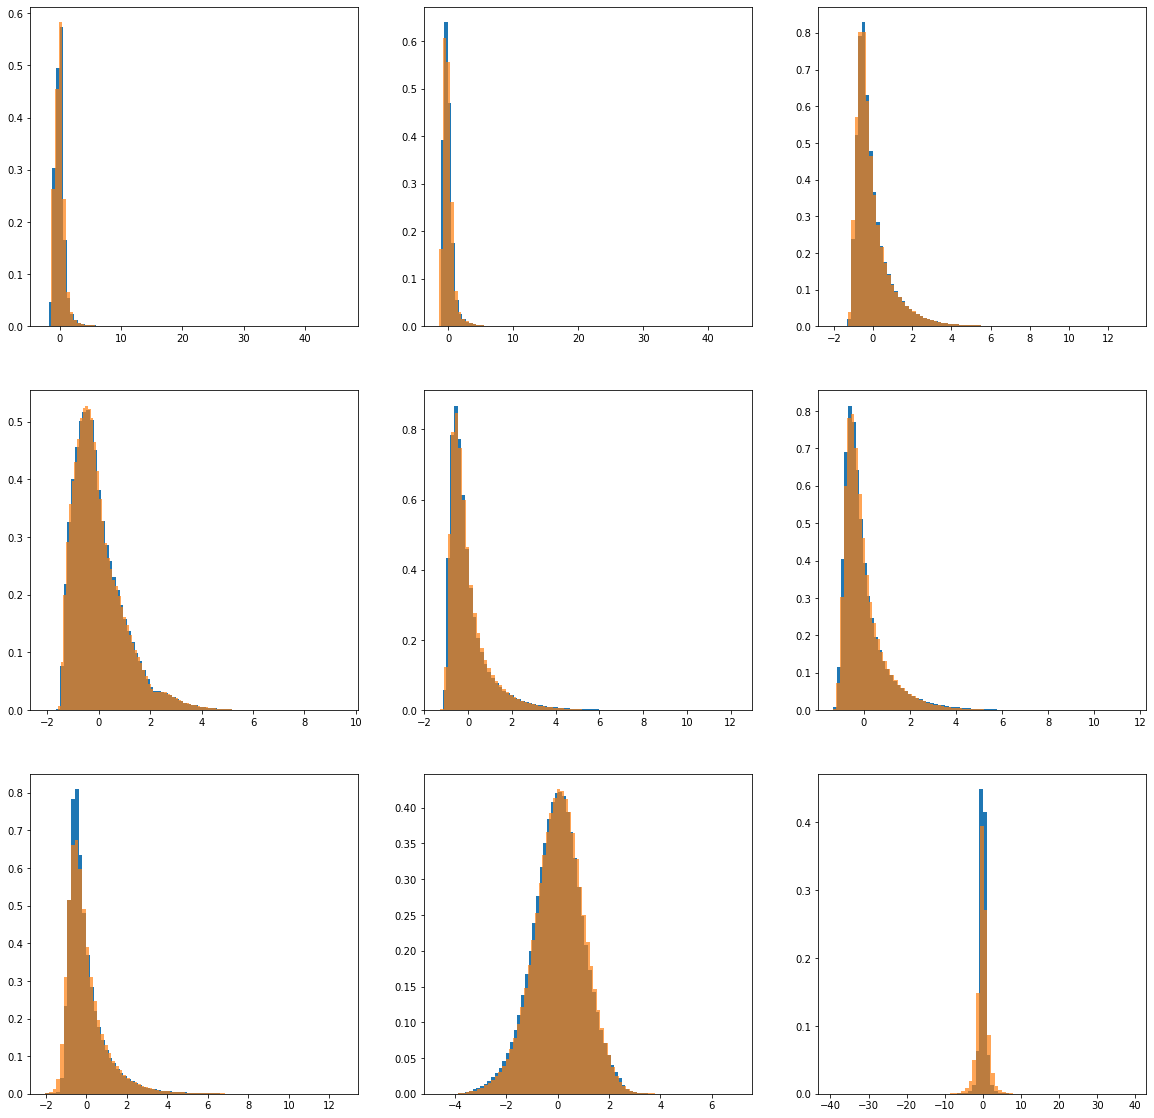

In [34]:
fig,ax = plt.subplots(3,3,figsize=(20,20))

hbins = 80


ax[0][0].hist( Xs_gen[:,0], density=True, bins=hbins )
ax[0][1].hist( Xs_gen[:,1], density=True, bins=hbins )
ax[0][2].hist( Xs_gen[:,2], density=True, bins=hbins )

ax[1][0].hist( Xs_gen[:,3], density=True, bins=hbins )
ax[1][1].hist( Xs_gen[:,4], density=True, bins=hbins )
ax[1][2].hist( Xs_gen[:,5], density=True, bins=hbins )

ax[2][0].hist( Xs_gen[:,6], density=True, bins=hbins )
ax[2][1].hist( Xs_gen[:,7], density=True, bins=hbins )
ax[2][2].hist( Xs_gen[:,8], density=True, bins=hbins )



ax[0][0].hist( Xs_obs[:,0], density=True, bins=hbins, alpha=0.7 )
ax[0][1].hist( Xs_obs[:,1], density=True, bins=hbins, alpha=0.7 )
ax[0][2].hist( Xs_obs[:,2], density=True, bins=hbins, alpha=0.7 )

ax[1][0].hist( Xs_obs[:,3], density=True, bins=hbins, alpha=0.7 )
ax[1][1].hist( Xs_obs[:,4], density=True, bins=hbins, alpha=0.7 )
ax[1][2].hist( Xs_obs[:,5], density=True, bins=hbins , alpha=0.7)

ax[2][0].hist( Xs_obs[:,6], density=True, bins=hbins, alpha=0.7 )
ax[2][1].hist( Xs_obs[:,7], density=True, bins=hbins , alpha=0.7)
ax[2][2].hist( Xs_obs[:,8], density=True, bins=hbins, alpha=0.7 )



plt.show()

## Comparison of gen with obs (particle with detector) , including event weights

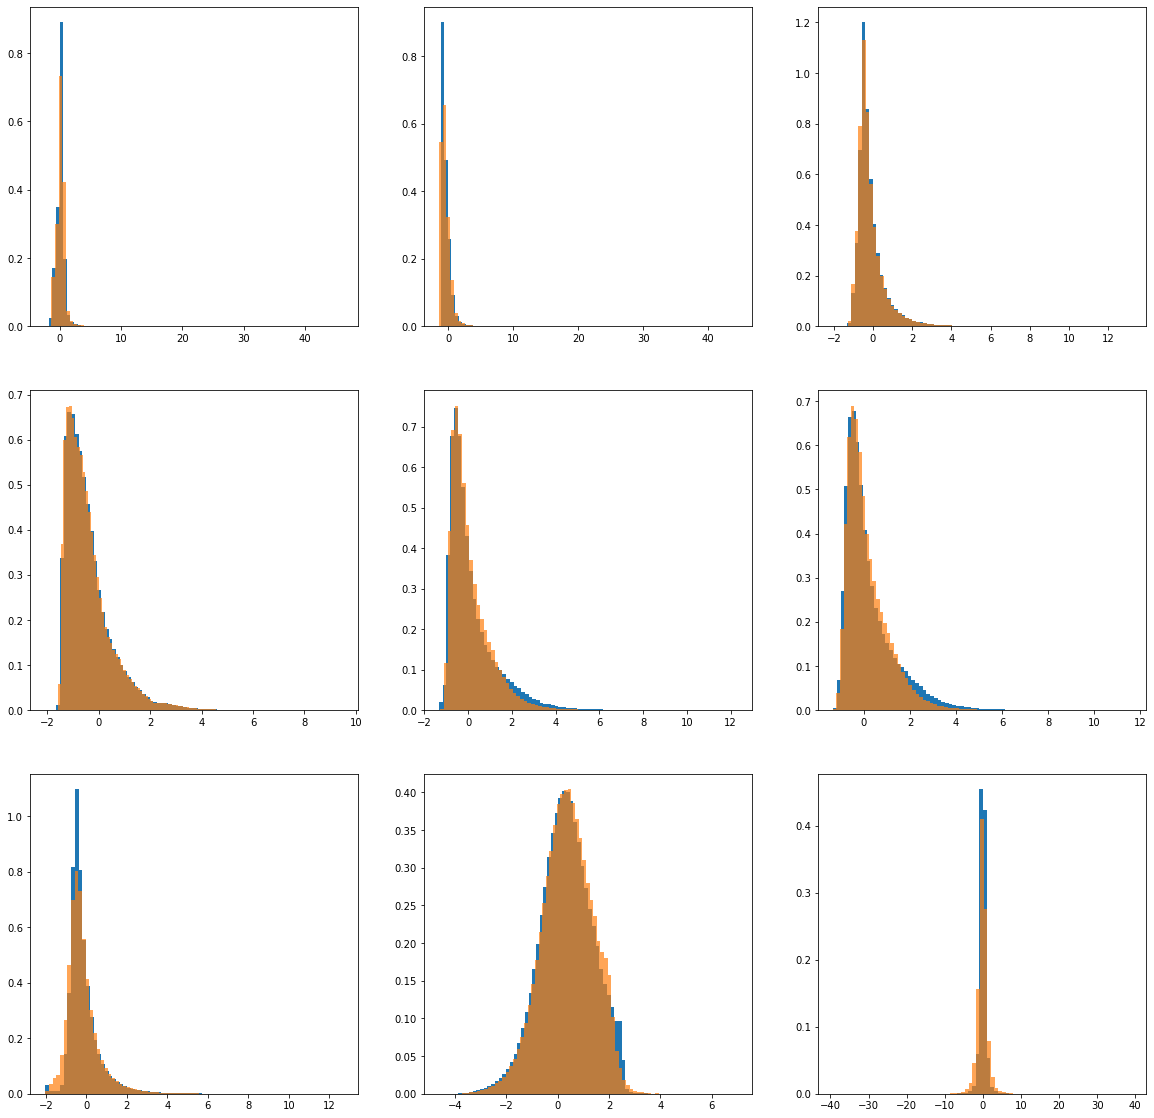

In [35]:
fig,ax = plt.subplots(3,3,figsize=(20,20))

hbins = 80


ax[0][0].hist( Xs_gen[:,0], density=True, bins=hbins, weights=w )
ax[0][1].hist( Xs_gen[:,1], density=True, bins=hbins, weights=w )
ax[0][2].hist( Xs_gen[:,2], density=True, bins=hbins, weights=w )

ax[1][0].hist( Xs_gen[:,3], density=True, bins=hbins, weights=w )
ax[1][1].hist( Xs_gen[:,4], density=True, bins=hbins, weights=w )
ax[1][2].hist( Xs_gen[:,5], density=True, bins=hbins, weights=w )

ax[2][0].hist( Xs_gen[:,6], density=True, bins=hbins, weights=w )
ax[2][1].hist( Xs_gen[:,7], density=True, bins=hbins, weights=w )
ax[2][2].hist( Xs_gen[:,8], density=True, bins=hbins, weights=w )



ax[0][0].hist( Xs_obs[:,0], density=True, bins=hbins, alpha=0.7, weights=w )
ax[0][1].hist( Xs_obs[:,1], density=True, bins=hbins, alpha=0.7, weights=w )
ax[0][2].hist( Xs_obs[:,2], density=True, bins=hbins, alpha=0.7, weights=w )

ax[1][0].hist( Xs_obs[:,3], density=True, bins=hbins, alpha=0.7, weights=w )
ax[1][1].hist( Xs_obs[:,4], density=True, bins=hbins, alpha=0.7, weights=w )
ax[1][2].hist( Xs_obs[:,5], density=True, bins=hbins, alpha=0.7, weights=w )

ax[2][0].hist( Xs_obs[:,6], density=True, bins=hbins, alpha=0.7, weights=w )
ax[2][1].hist( Xs_obs[:,7], density=True, bins=hbins, alpha=0.7, weights=w )
ax[2][2].hist( Xs_obs[:,8], density=True, bins=hbins, alpha=0.7, weights=w )



plt.show()

In [36]:
def weighted_binary_crossentropy(y_true, y_pred):
    weights = tf.gather(y_true, [1], axis=1) # event weights
    y_true = tf.gather(y_true, [0], axis=1) # actual y_true for loss
    
    # Clip the prediction value to prevent NaN's and Inf's
    epsilon = K.epsilon()
    y_pred = K.clip(y_pred, epsilon, 1. - epsilon)
    t_loss = -weights * ((y_true) * K.log(y_pred) +
                         (1 - y_true) * K.log(1 - y_pred))
    return K.mean(t_loss)

def weighted_mse(y_true, y_pred):
    weights = tf.gather(y_true, [1], axis=1) # event weights
    y_true = tf.gather(y_true, [0], axis=1) # actual y_true for loss
    return K.mean(weights*(y_true - y_pred)**2)

## Simple classifier (Django vs Rapgap), using only detector-level features

In [37]:
simple_model = Sequential()
simple_model.add(Dense(50, input_dim=9, activation='relu')) 
simple_model.add(Dense(50, activation='relu'))
simple_model.add(Dense(1, activation='sigmoid'))

opt_adam = tf.keras.optimizers.Adam(learning_rate=learning_rate_setval, amsgrad=False )

if use_weights :

    print("\n\n Including weighted_metrics in compile.\n\n")
    
    simple_model.compile(loss='binary_crossentropy', optimizer=opt_adam, metrics=['accuracy'], 
                      weighted_metrics=['accuracy'])
    
else :
        
    simple_model.compile(loss='binary_crossentropy', optimizer=opt_adam, metrics=['accuracy'])
        
        
        

2023-07-05 09:35:34.666386: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-07-05 09:35:34.666633: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-07-05 09:35:34.666804: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-07-05 09:35:34.667016: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-07-05 09:35:34.667199: I tensorflow/compiler/xla/stream_executo

In [38]:
#model = Sequential()
#model.add(Dense(150, input_dim=9, activation='relu')) 
#model.add(Dense(350, activation='relu'))
#model.add(Dense(150, activation='relu'))
#model.add(Dense(1, activation='sigmoid'))
#model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [39]:
#model = Sequential()
#model.add(Dense(150, input_dim=9, activation='relu')) 
#model.add(Dense(350, activation='relu'))
#model.add(Dense(350, activation='relu'))
#model.add(Dense(150, activation='relu'))
#model.add(Dense(1, activation='sigmoid'))
#model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [40]:
#model = Sequential()
#model.add(Dense(150, input_dim=9, activation='relu')) 
#model.add(Dense(350, activation='relu'))
#model.add(Dense(650, activation='relu'))
#model.add(Dense(350, activation='relu'))
#model.add(Dense(150, activation='relu'))
#model.add(Dense(1, activation='sigmoid'))
#model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [41]:
#model = Sequential()
#model.add(Dense(150, input_dim=9, activation='relu')) 
#model.add(Dense(350, activation='relu'))
#model.add(Dense(550, activation='relu'))
#model.add(Dense(850, activation='relu'))
#model.add(Dense(350, activation='relu'))
#model.add(Dense(150, activation='relu'))
#model.add(Dense(1, activation='sigmoid'))
#model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [42]:
from tensorflow.keras.callbacks import EarlyStopping
earlystopping = EarlyStopping(patience=20,
               verbose=True,
               restore_best_weights=True)

In [43]:
%%time


if run_training :
    
    if use_weights :

        print("\n\n Training with weights.\n\n")
        
        hist = simple_model.fit(X_obs_train, Y_train, validation_data=(X_obs_test, Y_test, w_test), epochs=max_epochs, 
                 batch_size=batch_size_setval,
                 sample_weight=w_train,
                 verbose = 1, callbacks=[earlystopping] )

  

    else :
        
        hist = simple_model.fit(X_obs_train, Y_train, validation_data=(X_obs_test, Y_test), epochs=max_epochs, 
                 batch_size=batch_size_setval,
                 verbose = 1, callbacks=[earlystopping] )        


CPU times: user 5 µs, sys: 2 µs, total: 7 µs
Wall time: 12.4 µs


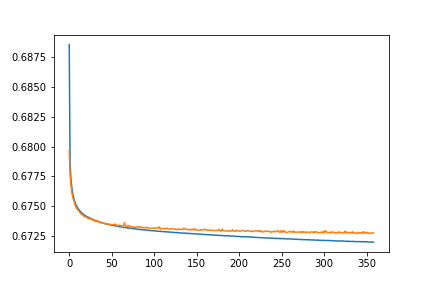

In [44]:
if run_training :
    plt.plot(hist.history['loss'])
    plt.plot(hist.history['val_loss'])
    plt.savefig('%s/loss-vs-epoch-simple-classifier-gen-inputs.pdf' % output_dir )
    plt.savefig('%s/loss-vs-epoch-simple-classifier-gen-inputs.png' % output_dir )

display.Image('%s/loss-vs-epoch-simple-classifier-gen-inputs.png' % output_dir )

In [45]:

if run_training :
    tf.keras.models.save_model( simple_model, '%s/model-simple-classifier-gen-inputs' % output_dir )
else :
    simple_model = tf.keras.models.load_model( '%s/model-simple-classifier-gen-inputs' % output_dir )
    

In [46]:
simple_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 50)                500       
                                                                 
 dense_1 (Dense)             (None, 50)                2550      
                                                                 
 dense_2 (Dense)             (None, 1)                 51        
                                                                 
Total params: 3,101
Trainable params: 3,101
Non-trainable params: 0
_________________________________________________________________


In [47]:
simple_classifier_output_gen = simple_model.predict( X_gen_test, batch_size=1024)
simple_classifier_output_obs = simple_model.predict( X_obs_test, batch_size=1024)

160/576 [=======>......................] - ETA: 0s

2023-07-05 09:35:35.860538: I tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:630] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.


576/576 [==============================] - 0s 580us/step


In [48]:
simple_classifier_output_django_gen = simple_model.predict( Xs_so_gen_d, batch_size=2048 )
simple_classifier_output_django_obs = simple_model.predict( Xs_so_obs_d, batch_size=2048 )
simple_classifier_output_rapgap_gen = simple_model.predict( Xs_so_gen_r, batch_size=2048 )
simple_classifier_output_rapgap_obs = simple_model.predict( Xs_so_obs_r, batch_size=2048 )

300/300 [==============================] - 0s 562us/step


Turning off weights.


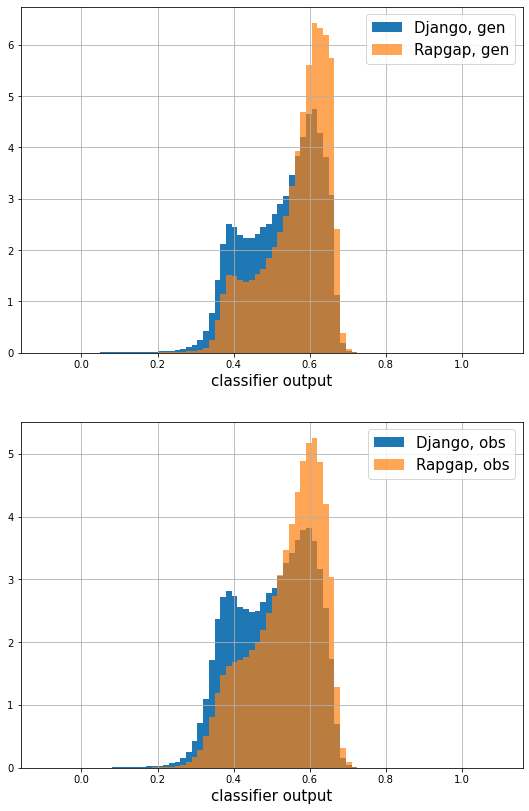

In [49]:
fig,ax = plt.subplots(2,1,figsize=(9,14))

hweights = w_test

if use_weights :
    print("Using weights.")
else :
    print("Turning off weights.")
    hweights.fill(1)



hist0 = ax[0].hist( simple_classifier_output_gen[Y_test==0], weights=hweights[Y_test==0], 
                   density=True, bins=80, range=[-0.1,1.1], label='Django, gen' )
hist1 = ax[0].hist( simple_classifier_output_gen[Y_test==1], weights=hweights[Y_test==1], 
                   density=True, bins=80, range=[-0.1,1.1], label='Rapgap, gen', alpha=0.7)

hist0_obs = ax[1].hist( simple_classifier_output_obs[Y_test==0], weights=hweights[Y_test==0], 
                       density=True, bins=80, range=[-0.1,1.1], label='Django, obs')
hist1_obs = ax[1].hist( simple_classifier_output_obs[Y_test==1], weights=hweights[Y_test==1], 
                       density=True, bins=80, range=[-0.1,1.1], label='Rapgap, obs', alpha=0.7)

ax[0].grid()
ax[1].grid()


hfontsize=15

ax[0].set_xlabel('classifier output', fontsize=hfontsize)
ax[1].set_xlabel('classifier output', fontsize=hfontsize)



ax[0].legend( loc='best', fontsize=hfontsize)
ax[1].legend( loc='best', fontsize=hfontsize)

plt.show()

Turning off weights.


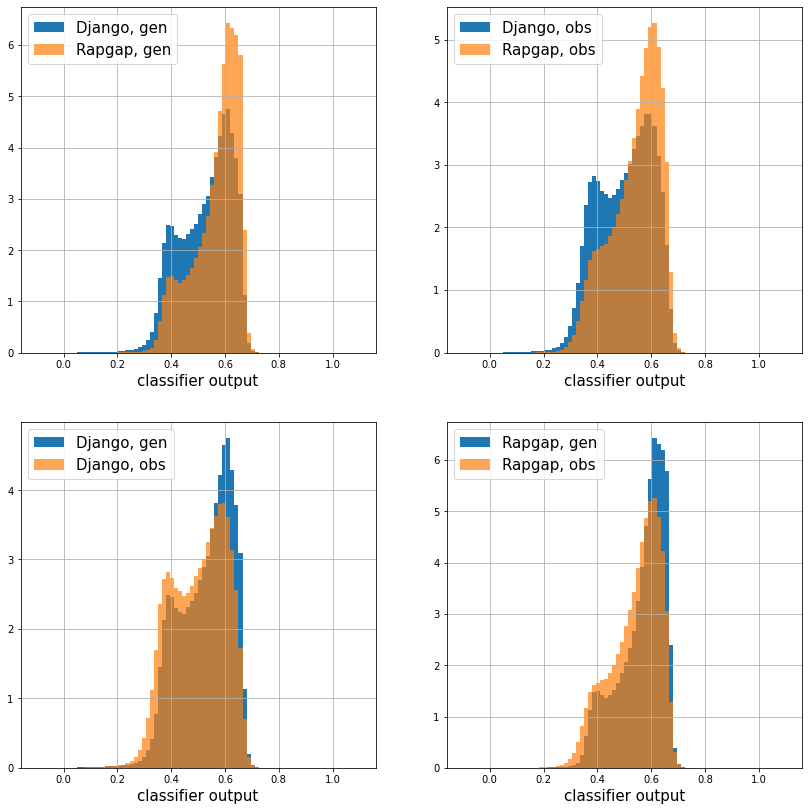

In [50]:
fig,ax = plt.subplots(2,2,figsize=(14,14))

hweights_r = w_r
hweights_d = w_d

if use_weights :
    print("Using weights.")
else :
    print("Turning off weights.")
    hweights_r.fill(1)
    hweights_d.fill(1)

ax[0][0].hist( simple_classifier_output_django_gen, weights=hweights_d,
              density=True, bins=80, range=[-0.1,1.1], label='Django, gen' )
ax[0][0].hist( simple_classifier_output_rapgap_gen, weights=hweights_r,
              density=True, bins=80, range=[-0.1,1.1], label='Rapgap, gen', alpha=0.7)
      
ax[0][1].hist( simple_classifier_output_django_obs, weights=hweights_d, 
              density=True, bins=80, range=[-0.1,1.1], label='Django, obs' )
ax[0][1].hist( simple_classifier_output_rapgap_obs, weights=hweights_r, 
              density=True, bins=80, range=[-0.1,1.1], label='Rapgap, obs', alpha=0.7)

ax[1][0].hist( simple_classifier_output_django_gen, weights=hweights_d, 
              density=True, bins=80, range=[-0.1,1.1], label='Django, gen' )
ax[1][0].hist( simple_classifier_output_django_obs, weights=hweights_d, 
              density=True, bins=80, range=[-0.1,1.1], label='Django, obs', alpha=0.7 )


ax[1][1].hist( simple_classifier_output_rapgap_gen, weights=hweights_r, 
              density=True, bins=80, range=[-0.1,1.1], label='Rapgap, gen' )
ax[1][1].hist( simple_classifier_output_rapgap_obs, weights=hweights_r, 
              density=True, bins=80, range=[-0.1,1.1], label='Rapgap, obs', alpha=0.7 )




ax[0][0].grid()
ax[0][1].grid()
ax[1][0].grid()
ax[1][1].grid()



hfontsize=15

ax[0][0].set_xlabel('classifier output', fontsize=hfontsize)
ax[1][0].set_xlabel('classifier output', fontsize=hfontsize)
ax[0][1].set_xlabel('classifier output', fontsize=hfontsize)
ax[1][1].set_xlabel('classifier output', fontsize=hfontsize)



ax[0][0].legend( loc='best', fontsize=hfontsize)
ax[1][0].legend( loc='best', fontsize=hfontsize)
ax[0][1].legend( loc='best', fontsize=hfontsize)
ax[1][1].legend( loc='best', fontsize=hfontsize)


plt.show()

Turning off weights.


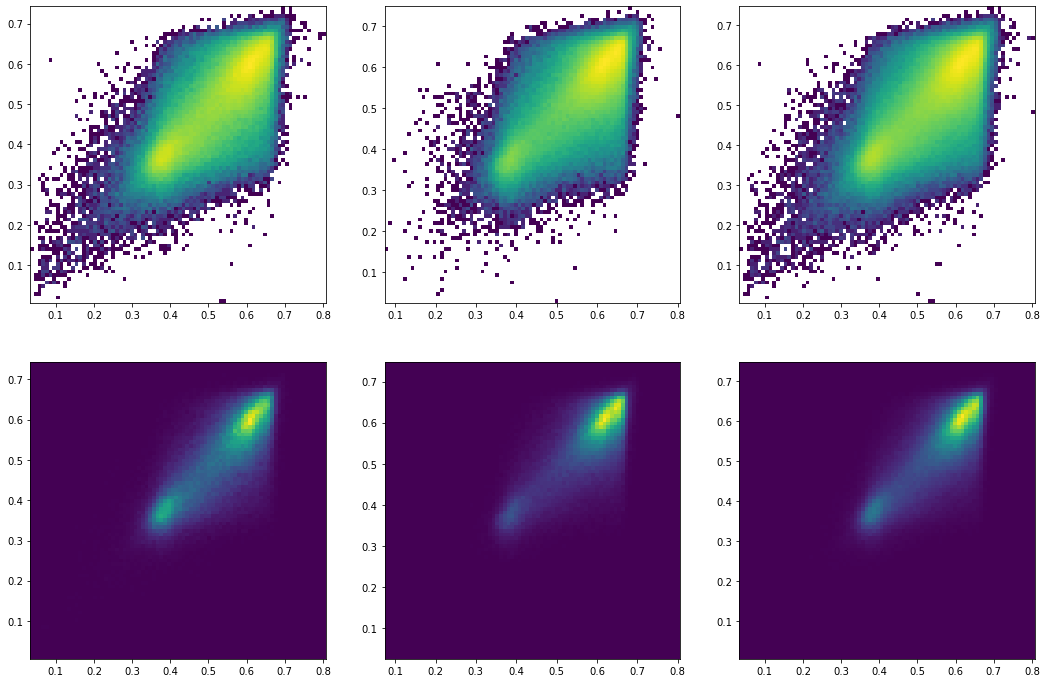

In [51]:
fig,ax = plt.subplots(2,3,figsize=(18,12))

hweights = w_test

if use_weights :
    print("Using weights.")
else :
    print("Turning off weights.")
    hweights.fill(1)



ax[0][0].hist2d( simple_classifier_output_gen[Y_test==0], 
                simple_classifier_output_obs[Y_test==0], 
                weights=hweights[Y_test==0],
                bins=80, norm=mpl.colors.LogNorm())
ax[0][1].hist2d( simple_classifier_output_gen[Y_test==1], 
                simple_classifier_output_obs[Y_test==1], 
                weights=hweights[Y_test==1], 
                bins=80, norm=mpl.colors.LogNorm())
ax[0][2].hist2d( simple_classifier_output_gen[Y_test>-1], 
                simple_classifier_output_obs[Y_test>-1], 
                weights=hweights[Y_test>-1], 
                bins=80, norm=mpl.colors.LogNorm())

ax[1][0].hist2d( simple_classifier_output_gen[Y_test==0], 
                simple_classifier_output_obs[Y_test==0], 
                weights=hweights[Y_test==0], 
                bins=80)
ax[1][1].hist2d( simple_classifier_output_gen[Y_test==1], 
                simple_classifier_output_obs[Y_test==1], 
                weights=hweights[Y_test==1], 
                bins=80)
ax[1][2].hist2d( simple_classifier_output_gen[Y_test>-1], 
                simple_classifier_output_obs[Y_test>-1], 
                weights=hweights[Y_test>-1], 
                bins=80)


plt.show()

In [52]:
from sklearn.metrics import roc_curve, auc,roc_auc_score

In [53]:
if use_weights :
    simple_fpr, simple_tpr, _ = roc_curve( Y_test, simple_classifier_output_obs, sample_weight=w_test)
else :
    simple_fpr, simple_tpr, _ = roc_curve( Y_test, simple_classifier_output_obs)

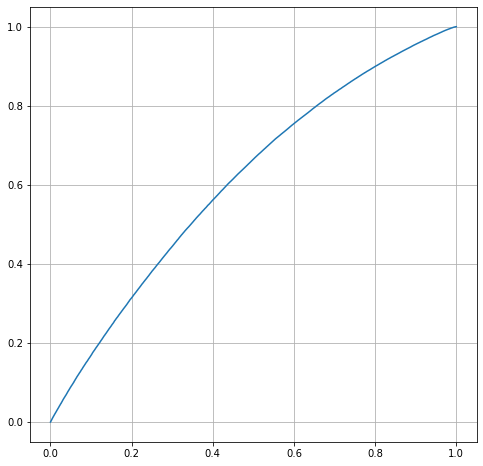

In [54]:
fig,ax = plt.subplots(1,1,figsize=(8,8))
plt.plot( simple_fpr, simple_tpr)
plt.grid()
plt.show()

In [55]:
total0 = sum(hist0[0])
total1 = sum(hist1[0])

npoints = len(hist0[0])
print('Number of points: %d' % npoints)

fr0 = np.zeros(npoints)
fr1 = np.zeros(npoints)

sum0 = float(0)
sum1 = float(0)

for i in range(npoints):
    sum0 += hist0[0][i]
    sum1 += hist1[0][i]
    fr0[i] = 1. - sum0/total0
    fr1[i] = 1. - sum1/total1
    print("  %2d :  fr0 = %7.3f  fr1 = %7.3f" % (i, fr0[i], fr1[i]))

Number of points: 80
   0 :  fr0 =   1.000  fr1 =   1.000
   1 :  fr0 =   1.000  fr1 =   1.000
   2 :  fr0 =   1.000  fr1 =   1.000
   3 :  fr0 =   1.000  fr1 =   1.000
   4 :  fr0 =   1.000  fr1 =   1.000
   5 :  fr0 =   1.000  fr1 =   1.000
   6 :  fr0 =   1.000  fr1 =   1.000
   7 :  fr0 =   1.000  fr1 =   1.000
   8 :  fr0 =   1.000  fr1 =   1.000
   9 :  fr0 =   1.000  fr1 =   1.000
  10 :  fr0 =   1.000  fr1 =   1.000
  11 :  fr0 =   1.000  fr1 =   1.000
  12 :  fr0 =   1.000  fr1 =   1.000
  13 :  fr0 =   0.999  fr1 =   1.000
  14 :  fr0 =   0.999  fr1 =   1.000
  15 :  fr0 =   0.999  fr1 =   1.000
  16 :  fr0 =   0.999  fr1 =   1.000
  17 :  fr0 =   0.999  fr1 =   1.000
  18 :  fr0 =   0.998  fr1 =   1.000
  19 :  fr0 =   0.998  fr1 =   1.000
  20 :  fr0 =   0.998  fr1 =   1.000
  21 :  fr0 =   0.997  fr1 =   1.000
  22 :  fr0 =   0.996  fr1 =   1.000
  23 :  fr0 =   0.996  fr1 =   0.999
  24 :  fr0 =   0.994  fr1 =   0.999
  25 :  fr0 =   0.993  fr1 =   0.999
  26 :  fr0 =   0

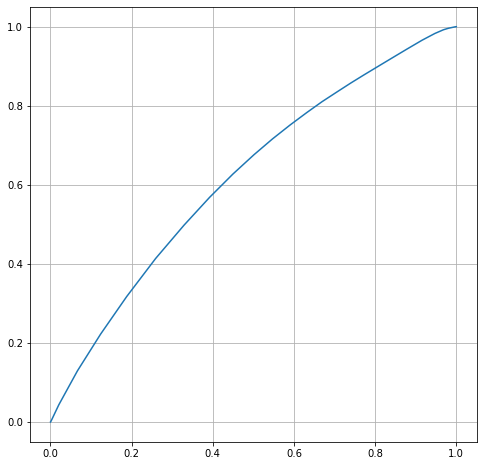

In [56]:
fig,ax = plt.subplots(1,1,figsize=(8,8))
plt.plot( fr0, fr1)
plt.grid()
plt.show()

## Classifier (Django vs Rapgap) with adversarial NN that penalizes gen vs obs discrimination.

In [57]:
X_gen_and_obs = np.concatenate( [X_gen_r, X_gen_d, X_obs_r, X_obs_d] )
w_gen_and_obs = np.concatenate( [w_r, w_d, w_r, w_d])
Y_gen_and_obs = np.concatenate( [Y_r, Y_d, Y_r, Y_d])
Z_gen_and_obs = np.concatenate( [np.zeros(len(X_gen_r)), np.zeros(len(X_gen_d)), np.ones(len(X_obs_r)), np.ones(len(X_obs_d))])

In [58]:

scaler_file = "%s/input-scaler-gen-and-obs.pkl" % output_dir

if run_training :
    print("Creating new scalar.")
    scalerX_gen_and_obs = StandardScaler()
    scalerX_gen_and_obs.fit(X_gen_and_obs)
else :
    print("Reading scaler from file: %s" % scaler_file )
    scalerX_gen_and_obs = load( open(scaler_file, 'rb') )
    
Xs_gen_and_obs = scalerX_gen_and_obs.transform(X_gen_and_obs)

if run_training :
    print( "Saving scalar to %s" % scaler_file )
    dump( scalerX_gen_and_obs, open(scaler_file, 'wb'))
    

Reading scaler from file: version4b-lambda1.00-no-weights-training-output/input-scaler-gen-and-obs.pkl


In [59]:
X_gen_and_obs_train, X_gen_and_obs_test, Y_gen_and_obs_train, Y_gen_and_obs_test, Z_gen_and_obs_train, Z_gen_and_obs_test, w_gen_and_obs_train, w_gen_and_obs_test = train_test_split( Xs_gen_and_obs, Y_gen_and_obs, Z_gen_and_obs, w_gen_and_obs, test_size=0.5 )

In [60]:
print("\n shapes:  X_gen_and_obs_train = %s " % str(np.shape(X_gen_and_obs_train)) )
print(" shapes:  Y_gen_and_obs_train = %s " % str(np.shape(Y_gen_and_obs_train)) )
print(" shapes:  Z_gen_and_obs_train = %s \n" % str(np.shape(Z_gen_and_obs_train)) )


 shapes:  X_gen_and_obs_train = (1177830, 9) 
 shapes:  Y_gen_and_obs_train = (1177830, 1) 
 shapes:  Z_gen_and_obs_train = (1177830,) 



In [61]:
@tf.custom_gradient
def grad_reverse(x, scale=10.):
    y = tf.identity(x)
    def custom_grad(dy):
        return -dy * scale
    return y, custom_grad

class GradReverse(tf.keras.layers.Layer):
    def __init__(self):
        super(GradReverse, self).__init__()

    def call(self, x):
        return grad_reverse(x)

In [62]:
n_hidden_inv = 2; n_hidden_inv_R = 5
n_nodes_inv = 50; n_nodes_inv_R = 50


inputs = Input(shape=(9,))
inputs_label = Input(shape=(1,))

Dx = Dense(n_nodes_inv, activation="relu")(inputs)
for i in range(n_hidden_inv -1):
    Dx = Dense(n_nodes_inv, activation='relu')(Dx)
Dx = Dense(1, activation="sigmoid", name="Clf")(Dx)
inv_model = Model(inputs=inputs, outputs=Dx)

GRx = GradReverse()(Dx)
GRx_con = tf.keras.layers.concatenate([GRx,inputs_label])
Rx = Dense(n_nodes_inv_R, activation="relu")(GRx_con)
for i in range(n_hidden_inv_R -1):
    Rx = Dense(n_nodes_inv_R, activation='relu')(Rx)

Rx = Dense(1, activation="sigmoid", name="Adv")(Rx)
GR = Model(inputs=[inputs,inputs_label], outputs=[Dx, Rx])

opt_adam = tf.keras.optimizers.Adam(learning_rate=learning_rate_setval, amsgrad=False )


if use_weights :
    
    print("\n\n Training with weights.\n\n")
        
    GR.compile(loss=["binary_crossentropy", "binary_crossentropy"], 
           loss_weights=[1,hp_lambda], optimizer=opt_adam,
           weighted_metrics=['accuracy']   ) 
else :
    GR.compile(loss=["binary_crossentropy", "binary_crossentropy"], 
           loss_weights=[1,hp_lambda], optimizer=opt_adam)     

In [63]:
%%time

if run_training :
    
    if use_weights :
        
        print("\n\n Training with weights.\n\n")

        GRhist = GR.fit(x=[X_gen_and_obs_train, Y_gen_and_obs_train], 
                y=[Y_gen_and_obs_train, Z_gen_and_obs_train], 
                sample_weight=[w_gen_and_obs_train, w_gen_and_obs_train],
                validation_data=([X_gen_and_obs_test, Y_gen_and_obs_test],[Y_gen_and_obs_test, Z_gen_and_obs_test], [w_gen_and_obs_test, w_gen_and_obs_test]) ,
                epochs=max_epochs, batch_size=batch_size_setval, verbose = 1, callbacks=[earlystopping] )

        
    else :
    
        GRhist = GR.fit(x=[X_gen_and_obs_train, Y_gen_and_obs_train], 
                y=[Y_gen_and_obs_train, Z_gen_and_obs_train], 
                validation_data=([X_gen_and_obs_test, Y_gen_and_obs_test],[Y_gen_and_obs_test, Z_gen_and_obs_test]),
                epochs=max_epochs, batch_size=batch_size_setval, verbose = 1, callbacks=[earlystopping] )
        
        

CPU times: user 5 µs, sys: 2 µs, total: 7 µs
Wall time: 12.6 µs


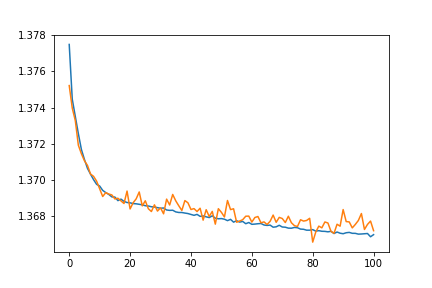

In [64]:
if run_training :
    plt.plot(GRhist.history['loss'])
    plt.plot(GRhist.history['val_loss'])
    plt.savefig('%s/loss-vs-epoch-adversarial-gen-and-obs-inputs.pdf' % output_dir )
    plt.savefig('%s/loss-vs-epoch-adversarial-gen-and-obs-inputs.png' % output_dir )

display.Image('%s/loss-vs-epoch-adversarial-gen-and-obs-inputs.png' % output_dir )

In [65]:
if run_training :
    tf.keras.models.save_model( GR, '%s/model-adversarial-gen-and-obs-inputs' % output_dir )
    tf.keras.models.save_model( inv_model, '%s/model-adversarial-gen-and-obs-inputs-classifier-only' % output_dir )
else :
    GR = tf.keras.models.load_model( '%s/model-adversarial-gen-and-obs-inputs' % output_dir )
    inv_model = tf.keras.models.load_model( '%s/model-adversarial-gen-and-obs-inputs-classifier-only' % output_dir )

In [66]:
GR.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 9)]          0           []                               
                                                                                                  
 dense_3 (Dense)                (None, 50)           500         ['input_1[0][0]']                
                                                                                                  
 dense_4 (Dense)                (None, 50)           2550        ['dense_3[0][0]']                
                                                                                                  
 Clf (Dense)                    (None, 1)            51          ['dense_4[0][0]']                
                                                                                            

In [67]:
inv_model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 9)]               0         
                                                                 
 dense_3 (Dense)             (None, 50)                500       
                                                                 
 dense_4 (Dense)             (None, 50)                2550      
                                                                 
 Clf (Dense)                 (None, 1)                 51        
                                                                 
Total params: 3,101
Trainable params: 3,101
Non-trainable params: 0
_________________________________________________________________


In [68]:
print(inputs)

KerasTensor(type_spec=TensorSpec(shape=(None, 9), dtype=tf.float32, name='input_1'), name='input_1', description="created by layer 'input_1'")


In [69]:
print(inputs_label)

KerasTensor(type_spec=TensorSpec(shape=(None, 1), dtype=tf.float32, name='input_2'), name='input_2', description="created by layer 'input_2'")


In [70]:
print(inv_model)

In [71]:
print(Dx)

KerasTensor(type_spec=TensorSpec(shape=(None, 1), dtype=tf.float32, name=None), name='Clf/Sigmoid:0', description="created by layer 'Clf'")


In [72]:
print(GRx)

KerasTensor(type_spec=TensorSpec(shape=(None, 1), dtype=tf.float32, name=None), name='grad_reverse/IdentityN:0', description="created by layer 'grad_reverse'")


In [73]:
print(GRx_con)

KerasTensor(type_spec=TensorSpec(shape=(None, 2), dtype=tf.float32, name=None), name='concatenate/concat:0', description="created by layer 'concatenate'")


In [74]:
print(Rx)

KerasTensor(type_spec=TensorSpec(shape=(None, 1), dtype=tf.float32, name=None), name='Adv/Sigmoid:0', description="created by layer 'Adv'")


In [75]:
print(GR)

In [76]:
classifier_output_adv = inv_model.predict( X_gen_and_obs_test, batch_size=2048 )

576/576 [==============================] - 0s 550us/step


In [77]:
Xs_gen_d = scalerX_gen_and_obs.transform( X_gen_d )
Xs_obs_d = scalerX_gen_and_obs.transform( X_obs_d )
Xs_gen_r = scalerX_gen_and_obs.transform( X_gen_r )
Xs_obs_r = scalerX_gen_and_obs.transform( X_obs_r )




classifier_output_django_gen = inv_model.predict( Xs_gen_d, batch_size=2048 )
classifier_output_django_obs = inv_model.predict( Xs_obs_d, batch_size=2048 )
classifier_output_rapgap_gen = inv_model.predict( Xs_gen_r, batch_size=2048 )
classifier_output_rapgap_obs = inv_model.predict( Xs_obs_r, batch_size=2048 )

300/300 [==============================] - 0s 542us/step


Turning off weights.


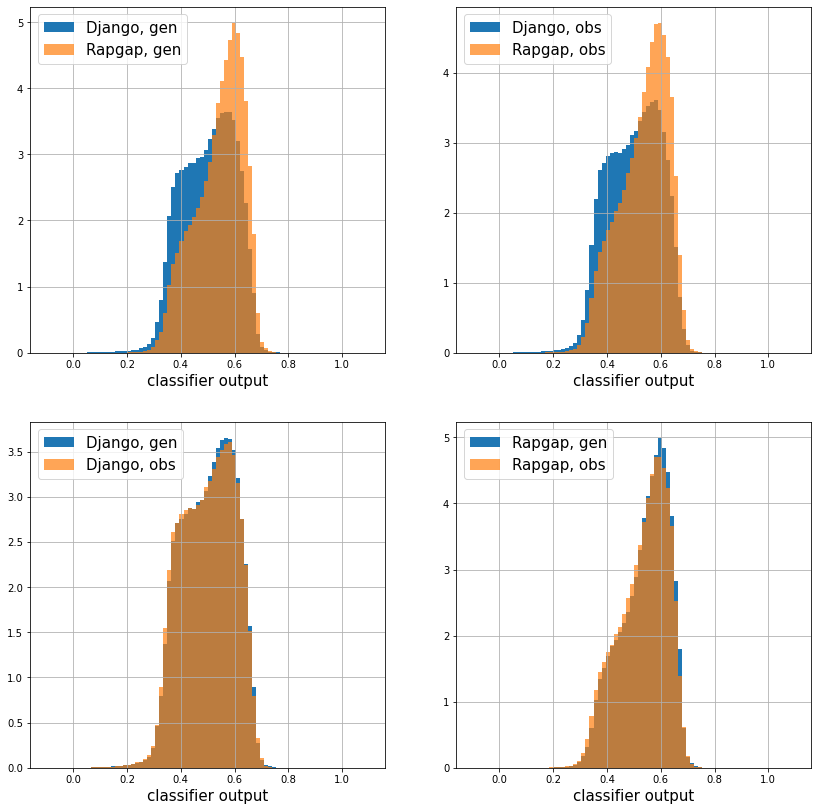

In [78]:
fig,ax = plt.subplots(2,2,figsize=(14,14))

hweights_r = w_r
hweights_d = w_d

if use_weights :
    print("Using weights.")
else :
    print("Turning off weights.")
    hweights_r.fill(1)
    hweights_d.fill(1)


ax[0][0].hist( classifier_output_django_gen, weights=hweights_d,
              density=True, bins=80, range=[-0.1,1.1], label='Django, gen' )
ax[0][0].hist( classifier_output_rapgap_gen, weights=hweights_r, 
              density=True, bins=80, range=[-0.1,1.1], label='Rapgap, gen', alpha=0.7)
      
ax[0][1].hist( classifier_output_django_obs, weights=hweights_d, 
              density=True, bins=80, range=[-0.1,1.1], label='Django, obs' )
ax[0][1].hist( classifier_output_rapgap_obs, weights=hweights_r, 
              density=True, bins=80, range=[-0.1,1.1], label='Rapgap, obs', alpha=0.7)

ax[1][0].hist( classifier_output_django_gen, weights=hweights_d, 
              density=True, bins=80, range=[-0.1,1.1], label='Django, gen' )
ax[1][0].hist( classifier_output_django_obs, weights=hweights_d, 
              density=True, bins=80, range=[-0.1,1.1], label='Django, obs', alpha=0.7 )


ax[1][1].hist( classifier_output_rapgap_gen, weights=hweights_r, 
              density=True, bins=80, range=[-0.1,1.1], label='Rapgap, gen' )
ax[1][1].hist( classifier_output_rapgap_obs, weights=hweights_r, 
              density=True, bins=80, range=[-0.1,1.1], label='Rapgap, obs', alpha=0.7 )




ax[0][0].grid()
ax[0][1].grid()
ax[1][0].grid()
ax[1][1].grid()



hfontsize=15

ax[0][0].set_xlabel('classifier output', fontsize=hfontsize)
ax[1][0].set_xlabel('classifier output', fontsize=hfontsize)
ax[0][1].set_xlabel('classifier output', fontsize=hfontsize)
ax[1][1].set_xlabel('classifier output', fontsize=hfontsize)



ax[0][0].legend( loc='best', fontsize=hfontsize)
ax[1][0].legend( loc='best', fontsize=hfontsize)
ax[0][1].legend( loc='best', fontsize=hfontsize)
ax[1][1].legend( loc='best', fontsize=hfontsize)


plt.show()

In [79]:
if use_weights :
    full_model_fpr, full_model_tpr, _ = roc_curve( Y_gen_and_obs_test, classifier_output_adv, sample_weight=w_gen_and_obs_test)
else :
    full_model_fpr, full_model_tpr, _ = roc_curve( Y_gen_and_obs_test, classifier_output_adv)

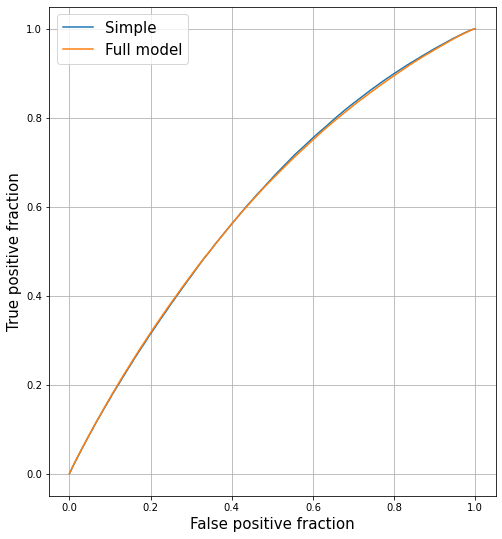

In [80]:
fig,ax = plt.subplots(1,1,figsize=(8,9))
plt.plot( simple_fpr, simple_tpr, label='Simple')
plt.plot( full_model_fpr, full_model_tpr, label='Full model')
plt.grid()
ax.set_xlabel('False positive fraction', fontsize=15)
ax.set_ylabel('True positive fraction', fontsize=15)
ax.legend( loc='best', fontsize=15)
plt.show()

In [81]:
overall_preds = GR.predict( [X_gen_and_obs_test, Y_gen_and_obs_test], batch_size=2048 )

576/576 [==============================] - 1s 948us/step


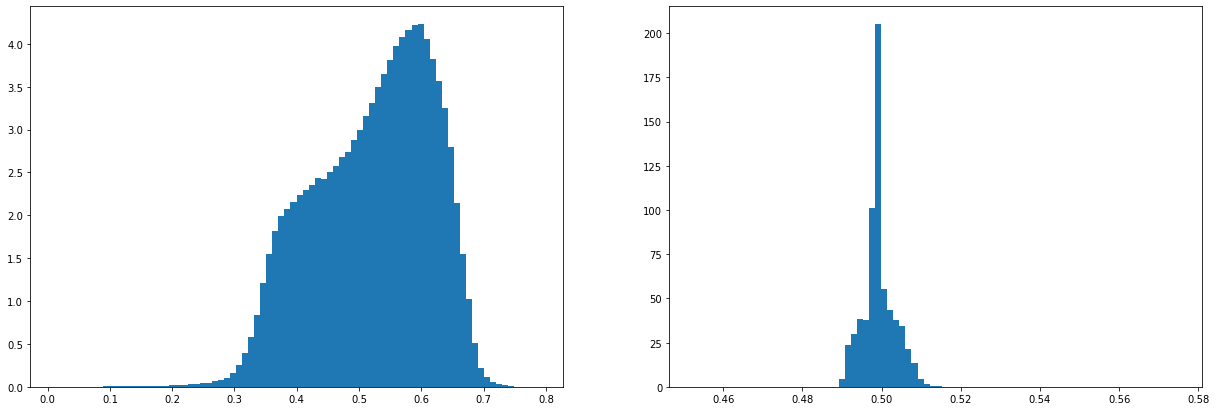

In [82]:
fig,ax = plt.subplots(1,2,figsize=(21,7))

ax[0].hist( overall_preds[0], bins=80, density=True )

ax[1].hist( overall_preds[1], bins=80, density=True )

plt.show()

## Inspect the adversary NN function and compare to what is expected, derived from histograms

In [83]:
%%time

#-- arrgh.  Can't figure out how to do this in the numpy way that doesn't take a ton of memory...  
#   Do it the slow way.

preds_clf_r_gen = np.zeros(len(Y_gen_and_obs_test))
preds_clf_r_obs = np.zeros(len(Y_gen_and_obs_test))
preds_clf_d_gen = np.zeros(len(Y_gen_and_obs_test))
preds_clf_d_obs = np.zeros(len(Y_gen_and_obs_test))

w_r_gen = np.zeros(len(Y_gen_and_obs_test))
w_r_obs = np.zeros(len(Y_gen_and_obs_test))
w_d_gen = np.zeros(len(Y_gen_and_obs_test))
w_d_obs = np.zeros(len(Y_gen_and_obs_test))

count_r_gen = 0
count_r_obs = 0
count_d_gen = 0
count_d_obs = 0

for i in range(len(overall_preds[0])):
    
    if i%100000 == 0 :
        print(i)
        
    if Y_gen_and_obs_test[i] == 1 and Z_gen_and_obs_test[i] == 0 :
        preds_clf_r_gen[count_r_gen] =  overall_preds[0][i]
        w_r_gen[count_r_gen] =  w_gen_and_obs_test[i] 
        count_r_gen = count_r_gen + 1
        
    if Y_gen_and_obs_test[i] == 1 and Z_gen_and_obs_test[i] == 1 :
        preds_clf_r_obs[count_r_obs] =  overall_preds[0][i] 
        w_r_obs[count_r_obs] =  w_gen_and_obs_test[i] 
        count_r_obs = count_r_obs + 1
        
    if Y_gen_and_obs_test[i] == 0 and Z_gen_and_obs_test[i] == 0 :
        preds_clf_d_gen[count_d_gen] = overall_preds[0][i] 
        w_d_gen[count_d_gen] = w_gen_and_obs_test[i] 
        count_d_gen = count_d_gen + 1
        
    if Y_gen_and_obs_test[i] == 0 and Z_gen_and_obs_test[i] == 1 :
        preds_clf_d_obs[count_d_obs] = overall_preds[0][i] 
        w_d_obs[count_d_obs] = w_gen_and_obs_test[i] 
        count_d_obs = count_d_obs + 1
        

        
preds_clf_r_gen = np.resize(preds_clf_r_gen,[count_r_gen])
w_r_gen = np.resize(w_r_gen,[count_r_gen])

preds_clf_r_obs = np.resize(preds_clf_r_obs,[count_r_obs])
w_r_obs = np.resize(w_r_obs,[count_r_obs])

preds_clf_d_gen = np.resize(preds_clf_d_gen,[count_d_gen])
w_d_gen = np.resize(w_d_gen,[count_d_gen])

preds_clf_d_obs = np.resize(preds_clf_d_obs,[count_d_obs])
w_d_obs = np.resize(w_d_obs,[count_d_obs])




0
100000
200000
300000
400000
500000
600000
700000
800000
900000
1000000
1100000
CPU times: user 7.48 s, sys: 8.77 ms, total: 7.48 s
Wall time: 7.48 s


Turning off weights.


/tmp/ipykernel_329844/2370017081.py:60: RuntimeWarning: invalid value encountered in double_scalars
  herr_r[i] = np.sqrt( hprobr[i]*(1-hprobr[i])/(o+g) )  #-- incorrect when using weights.
/tmp/ipykernel_329844/2370017081.py:64: RuntimeWarning: invalid value encountered in double_scalars
  herr_d[i] = np.sqrt( hprobd[i]*(1-hprobd[i])/(o+g) )  #-- incorrect when using weights.


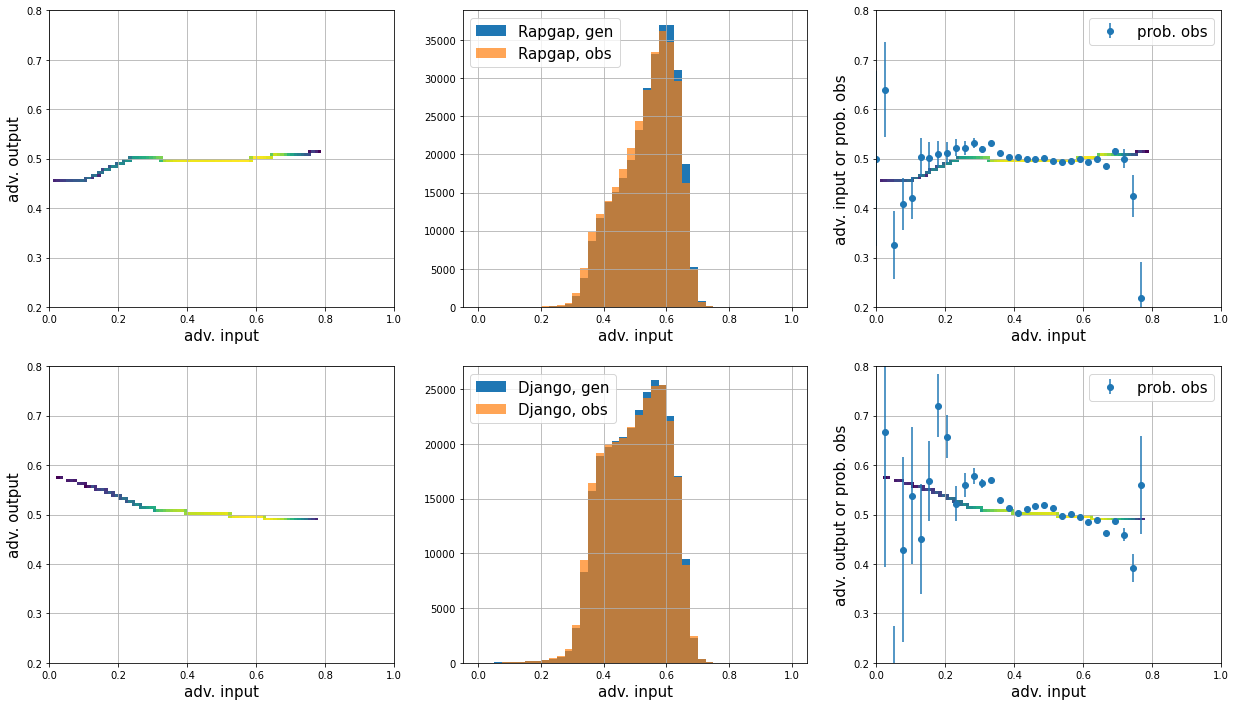

In [84]:
fig,ax = plt.subplots(2,3,figsize=(21,12))

hbins=40

hymin=0.20
hymax=0.80


hweights = w_gen_and_obs_test


if use_weights :
    print("Using weights.")
else :
    print("Turning off weights.")
    hweights.fill(1)
    w_r_gen.fill(1)
    w_r_obs.fill(1)
    w_d_gen.fill(1)
    w_d_obs.fill(1)



ax[0][0].hist2d( overall_preds[0][Y_gen_and_obs_test==0], 
                overall_preds[1][Y_gen_and_obs_test==0], 
                weights=hweights[Y_gen_and_obs_test==0],
                bins=100, norm=mpl.colors.LogNorm(), range=([0,1],[hymin,hymax]) )

ax[1][0].hist2d( overall_preds[0][Y_gen_and_obs_test==1], 
                overall_preds[1][Y_gen_and_obs_test==1], 
                weights=hweights[Y_gen_and_obs_test==1],
                bins=100, norm=mpl.colors.LogNorm(), range=([0,1],[hymin,hymax]) )



hrg = ax[0][1].hist( preds_clf_r_gen, weights=w_r_gen,
                    bins=hbins, range=[0,1], label='Rapgap, gen' )
hro = ax[0][1].hist( preds_clf_r_obs, weights=w_r_obs,
                    bins=hbins, range=[0,1], label='Rapgap, obs', alpha=0.7 )

hdg = ax[1][1].hist( preds_clf_d_gen, weights=w_d_gen,
                    bins=hbins, range=[0,1], label='Django, gen'  )
hdo = ax[1][1].hist( preds_clf_d_obs, weights=w_d_obs,
                    bins=hbins, range=[0,1], label='Django, obs', alpha=0.7 )





hprobr = np.zeros(len(hro[0]) )
hprobd = np.zeros(len(hdo[0]) )
herr_r = np.zeros(len(hro[0]) )
herr_d = np.zeros(len(hdo[0]) )

paxis = np.linspace( 0, 1, len(hro[0]) )
for i in range(len(hro[0])):
    o = hro[0][i]
    g = hrg[0][i]
    if o != 0 and g != 0 : hprobr[i] = o / (o+g)
    herr_r[i] = np.sqrt( hprobr[i]*(1-hprobr[i])/(o+g) )  #-- incorrect when using weights.
    o = hdo[0][i]
    g = hdg[0][i]
    if o != 0 and g != 0 : hprobd[i] = o / (o+g)
    herr_d[i] = np.sqrt( hprobd[i]*(1-hprobd[i])/(o+g) )  #-- incorrect when using weights.

 



ax[0][2].hist2d( overall_preds[0][Y_gen_and_obs_test==0], 
                overall_preds[1][Y_gen_and_obs_test==0], 
                bins=100, norm=mpl.colors.LogNorm(), range=([0,1],[hymin,hymax]),
               label='adv. output')

ax[0][2].errorbar( paxis, hprobd, yerr=herr_d, fmt='o', label='prob. obs' ) 




ax[1][2].hist2d( overall_preds[0][Y_gen_and_obs_test==1], 
                overall_preds[1][Y_gen_and_obs_test==1], 
                bins=100, norm=mpl.colors.LogNorm(), range=([0,1],[hymin,hymax]) )

ax[1][2].errorbar( paxis, hprobr, yerr=herr_r, fmt='o', label='prob. obs' ) 



ax[0][0].grid()
ax[0][1].grid()
ax[0][2].grid()


ax[1][0].grid()
ax[1][1].grid()
ax[1][2].grid()




fontsize=15

ax[0][0].set_xlabel('adv. input', fontsize=hfontsize)
ax[0][0].set_ylabel('adv. output', fontsize=hfontsize)

ax[1][0].set_xlabel('adv. input', fontsize=hfontsize)
ax[1][0].set_ylabel('adv. output', fontsize=hfontsize)

ax[0][1].set_xlabel('adv. input', fontsize=hfontsize)
ax[0][2].set_xlabel('adv. input', fontsize=hfontsize)
ax[1][1].set_xlabel('adv. input', fontsize=hfontsize)
ax[1][2].set_xlabel('adv. input', fontsize=hfontsize)

ax[0][2].set_ylabel('adv. input or prob. obs', fontsize=hfontsize)
ax[1][2].set_ylabel('adv. output or prob. obs', fontsize=hfontsize)



ax[0][1].legend( loc='best', fontsize=hfontsize)
ax[1][1].legend( loc='best', fontsize=hfontsize)

ax[0][2].legend( loc='best', fontsize=hfontsize)
ax[1][2].legend( loc='best', fontsize=hfontsize)

    
plt.show()

## Test with Lambda = 0 to turn off adversary

In [85]:
n_hidden_inv = 2; n_hidden_inv_R = 5
n_nodes_inv = 50; n_nodes_inv_R = 50
hp_lambda0 = 0.

inputs = Input(shape=(9,))
inputs_label = Input(shape=(1,))

Dx_lam0 = Dense(n_nodes_inv, activation="relu")(inputs)
for i in range(n_hidden_inv -1):
    Dx_lam0 = Dense(n_nodes_inv, activation='relu')(Dx_lam0)
Dx_lam0 = Dense(1, activation="sigmoid", name="Clf")(Dx_lam0)
inv_model_lam0 = Model(inputs=inputs, outputs=Dx_lam0)

GRx_lam0 = GradReverse()(Dx_lam0)
GRx_con_lam0 = tf.keras.layers.concatenate([GRx_lam0,inputs_label])
Rx_lam0 = Dense(n_nodes_inv_R, activation="relu")(GRx_con_lam0)
for i in range(n_hidden_inv_R -1):
    Rx_lam0 = Dense(n_nodes_inv_R, activation='relu')(Rx_lam0)

Rx_lam0 = Dense(1, activation="sigmoid", name="Adv")(Rx_lam0)
GR_lam0 = Model(inputs=[inputs,inputs_label], outputs=[Dx_lam0, Rx_lam0])

opt_adam = tf.keras.optimizers.Adam(learning_rate=learning_rate_setval, amsgrad=False )


if use_weights :
    
    print("\n\n Training with weights\n\n")    

    GR_lam0.compile(loss=["binary_crossentropy", "binary_crossentropy"], 
                loss_weights=[1,hp_lambda0], optimizer=opt_adam,
                       weighted_metrics=['accuracy'])
else :

    GR_lam0.compile(loss=["binary_crossentropy", "binary_crossentropy"], 
                loss_weights=[1,hp_lambda0], optimizer=opt_adam)

In [86]:
%%time

if run_training :
    
    if use_weights :
        
        print("\n\n Training with weights\n\n")    
        
        GRhist_lam0 = GR_lam0.fit(x=[X_gen_and_obs_train, Y_gen_and_obs_train], 
                y=[Y_gen_and_obs_train, Z_gen_and_obs_train],
                sample_weight=[w_gen_and_obs_train, w_gen_and_obs_train],
                validation_data=([X_gen_and_obs_test, Y_gen_and_obs_test],[Y_gen_and_obs_test, Z_gen_and_obs_test], [w_gen_and_obs_test, w_gen_and_obs_test]),
                epochs=max_epochs, batch_size=batch_size_setval, verbose = 1, callbacks=[earlystopping] )
        
    else :
    
        GRhist_lam0 = GR_lam0.fit(x=[X_gen_and_obs_train, Y_gen_and_obs_train], 
                y=[Y_gen_and_obs_train, Z_gen_and_obs_train], 
                validation_data=([X_gen_and_obs_test, Y_gen_and_obs_test],[Y_gen_and_obs_test, Z_gen_and_obs_test]),
                epochs=max_epochs, batch_size=batch_size_setval, verbose = 1, callbacks=[earlystopping] )

CPU times: user 5 µs, sys: 2 µs, total: 7 µs
Wall time: 13.6 µs


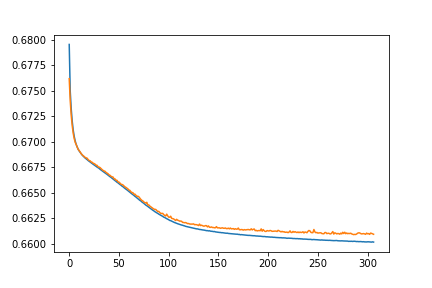

In [87]:
if run_training :
    plt.plot(GRhist_lam0.history['loss'])
    plt.plot(GRhist_lam0.history['val_loss'])
    plt.savefig('%s/loss-vs-epoch-adversarial-gen-and-obs-inputs-lambda0.pdf' % output_dir )
    plt.savefig('%s/loss-vs-epoch-adversarial-gen-and-obs-inputs-lambda0.png' % output_dir )

display.Image('%s/loss-vs-epoch-adversarial-gen-and-obs-inputs-lambda0.png' % output_dir )

In [88]:
if run_training :
    tf.keras.models.save_model( GR_lam0, '%s/model-adversarial-gen-and-obs-inputs-lambda0' % output_dir )
    tf.keras.models.save_model( inv_model_lam0, '%s/model-adversarial-gen-and-obs-inputs-lambda0-classifier-only' % output_dir )
else :
    GR_lam0 = tf.keras.models.load_model( '%s/model-adversarial-gen-and-obs-inputs-lambda0' % output_dir )
    inv_model_lam0 = tf.keras.models.load_model( '%s/model-adversarial-gen-and-obs-inputs-lambda0-classifier-only' % output_dir )

In [89]:
GR_lam0.summary()

Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 9)]          0           []                               
                                                                                                  
 dense_10 (Dense)               (None, 50)           500         ['input_3[0][0]']                
                                                                                                  
 dense_11 (Dense)               (None, 50)           2550        ['dense_10[0][0]']               
                                                                                                  
 Clf (Dense)                    (None, 1)            51          ['dense_11[0][0]']               
                                                                                            

In [90]:
inv_model_lam0.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 9)]               0         
                                                                 
 dense_10 (Dense)            (None, 50)                500       
                                                                 
 dense_11 (Dense)            (None, 50)                2550      
                                                                 
 Clf (Dense)                 (None, 1)                 51        
                                                                 
Total params: 3,101
Trainable params: 3,101
Non-trainable params: 0
_________________________________________________________________


In [91]:

classifier_output_django_gen_lam0 = inv_model_lam0.predict( Xs_gen_d, batch_size=2048 )
classifier_output_django_obs_lam0 = inv_model_lam0.predict( Xs_obs_d, batch_size=2048 )
classifier_output_rapgap_gen_lam0 = inv_model_lam0.predict( Xs_gen_r, batch_size=2048 )
classifier_output_rapgap_obs_lam0 = inv_model_lam0.predict( Xs_obs_r, batch_size=2048 )

300/300 [==============================] - 0s 546us/step


Turning off weights.


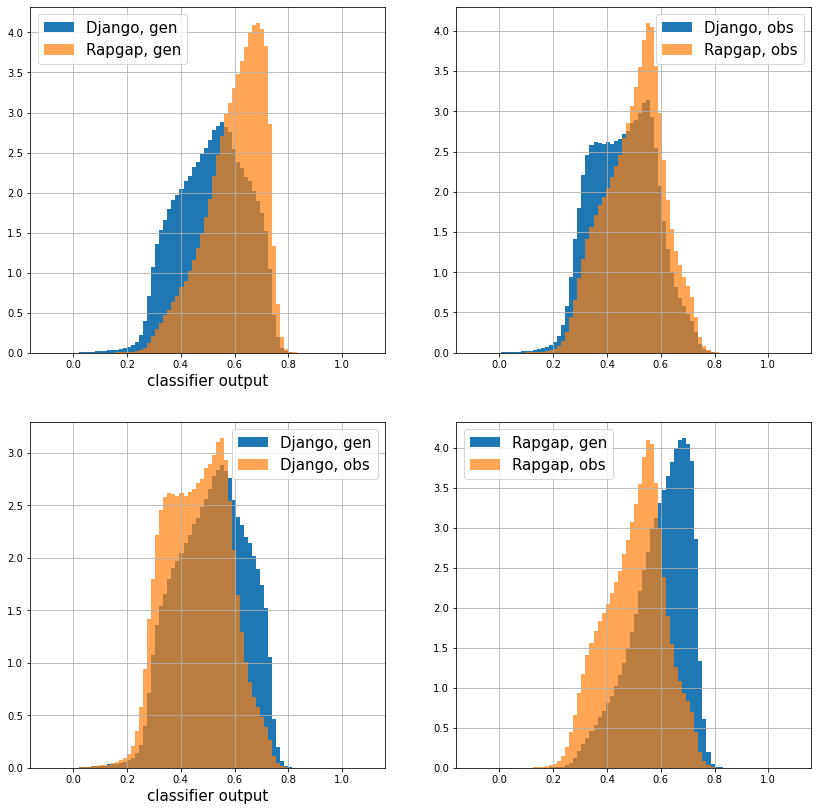

In [92]:
fig,ax = plt.subplots(2,2,figsize=(14,14))

hweights_r = w_r
hweights_d = w_d

if use_weights :
    print("Using weights.")
else :
    print("Turning off weights.")
    hweights_r.fill(1)
    hweights_d.fill(1)


ax[0][0].hist( classifier_output_django_gen_lam0, weights=hweights_d,
              density=True, bins=80, range=[-0.1,1.1], label='Django, gen' )
ax[0][0].hist( classifier_output_rapgap_gen_lam0, weights=hweights_r,
              density=True, bins=80, range=[-0.1,1.1], label='Rapgap, gen', alpha=0.7)
      
ax[0][1].hist( classifier_output_django_obs_lam0, weights=hweights_d,
              density=True, bins=80, range=[-0.1,1.1], label='Django, obs' )
ax[0][1].hist( classifier_output_rapgap_obs_lam0, weights=hweights_r,
              density=True, bins=80, range=[-0.1,1.1], label='Rapgap, obs', alpha=0.7)

ax[1][0].hist( classifier_output_django_gen_lam0, weights=hweights_d,
              density=True, bins=80, range=[-0.1,1.1], label='Django, gen' )
ax[1][0].hist( classifier_output_django_obs_lam0, weights=hweights_d,
              density=True, bins=80, range=[-0.1,1.1], label='Django, obs', alpha=0.7 )


ax[1][1].hist( classifier_output_rapgap_gen_lam0, weights=hweights_r,
              density=True, bins=80, range=[-0.1,1.1], label='Rapgap, gen' )
ax[1][1].hist( classifier_output_rapgap_obs_lam0, weights=hweights_r,
              density=True, bins=80, range=[-0.1,1.1], label='Rapgap, obs', alpha=0.7 )




ax[0][0].grid()
ax[0][1].grid()
ax[1][0].grid()
ax[1][1].grid()



hfontsize=15

ax[0][0].set_xlabel('classifier output', fontsize=hfontsize)
ax[1][0].set_xlabel('classifier output', fontsize=hfontsize)




ax[0][0].legend( loc='best', fontsize=hfontsize)
ax[1][0].legend( loc='best', fontsize=hfontsize)
ax[0][1].legend( loc='best', fontsize=hfontsize)
ax[1][1].legend( loc='best', fontsize=hfontsize)


plt.show()

In [93]:
classifier_output_adv_lam0 = inv_model_lam0.predict( X_gen_and_obs_test, batch_size=2048 )

576/576 [==============================] - 0s 578us/step


In [94]:
if use_weights :
    full_model_lam0_fpr, full_model_lam0_tpr, _ = roc_curve( Y_gen_and_obs_test, classifier_output_adv_lam0, sample_weight=w_gen_and_obs_test)
else :
    full_model_lam0_fpr, full_model_lam0_tpr, _ = roc_curve( Y_gen_and_obs_test, classifier_output_adv_lam0)

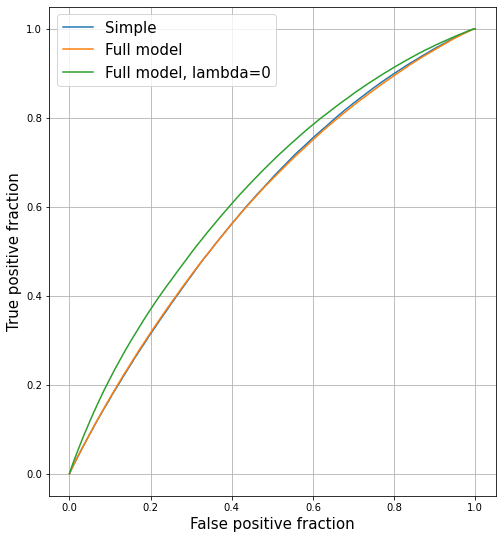

In [95]:
fig,ax = plt.subplots(1,1,figsize=(8,9))
plt.plot( simple_fpr, simple_tpr, label='Simple')
plt.plot( full_model_fpr, full_model_tpr, label='Full model')
plt.plot( full_model_lam0_fpr, full_model_lam0_tpr, label='Full model, lambda=0')
plt.grid()
ax.set_xlabel('False positive fraction', fontsize=15)
ax.set_ylabel('True positive fraction', fontsize=15)
ax.legend( loc='best', fontsize=15)
plt.show()

## Compare the response matrix for the  Simple classifier with the Full model
Here, the distribution is of the classifier output and we look at unfolding the distribution from detector-level inputs to the "true" distribution from particle-level inputs.

In [96]:
full_classifier_output_gen = inv_model.predict( Xs_gen, batch_size=2048 )
full_classifier_output_obs = inv_model.predict( Xs_obs, batch_size=2048 )

576/576 [==============================] - 0s 543us/step


Turning off weights.


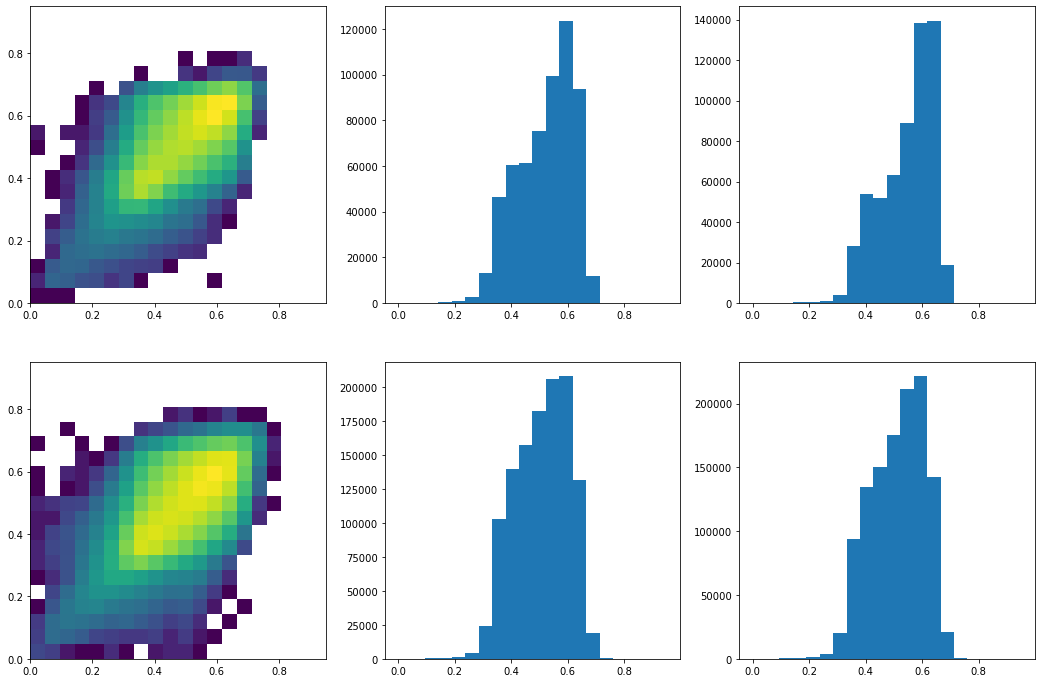

In [97]:
fig,ax = plt.subplots(2,3,figsize=(18,12))

response_min = 0.0
response_max = 0.95
response_bins = 20

hweights = w_test

if use_weights :
    print("Using weights.")
else :
    print("Turning off weights.")
    hweights.fill(1)




hist_simple = ax[0][0].hist2d( simple_classifier_output_obs[:,0], 
                simple_classifier_output_gen[:,0], 
                weights=hweights[:,0], 
                range=([response_min,response_max],[response_min,response_max]),
                bins=response_bins, 
                              norm=mpl.colors.LogNorm()
                             )

hist_simple_obs = ax[0][1].hist( 
                simple_classifier_output_obs[:,0], 
                range=[response_min,response_max],
                weights=hweights[:,0], 
                bins=response_bins)

hist_simple_gen = ax[0][2].hist( 
                simple_classifier_output_gen[:,0], 
                range=[response_min,response_max],
                weights=hweights[:,0], 
                bins=response_bins)


#-- Need to have obs/gen pairs for full model!
hist_full = ax[1][0].hist2d( full_classifier_output_obs[:,0], 
                full_classifier_output_gen[:,0],  
                range=([response_min,response_max],[response_min,response_max]),
                bins=response_bins, norm=mpl.colors.LogNorm())

hist_full_obs = ax[1][1].hist( 
                full_classifier_output_obs[:,0], 
                range=[response_min,response_max],
                bins=response_bins)

hist_full_gen = ax[1][2].hist( 
                full_classifier_output_gen[:,0], 
                range=[response_min,response_max],
                bins=response_bins)


plt.show()

In [98]:

# first 2d array index is x axis (obs), 
# second 2d array index is y axis (gen)

# for response matrix, make normalized distribution in obs (x) for each gen bin (y)


response_data_simple = np.copy(hist_simple[0])
response_data_full = np.copy(hist_full[0])

for j in range(len(hist_simple[0])) :
    print(" %2d : " % i, end="")
    sum_simple = 0
    sum_full = 0
    for i in range( len(hist_simple[0])) :
        sum_simple = sum_simple + hist_simple[0][i][j]
        sum_full = sum_full + hist_full[0][i][j]

    print( ":  sum = %9.1f   gen = %9.1f   obs = %9.1f" % (sum_simple, hist_simple_gen[0][j], hist_simple_obs[0][j]))
    for i in range( len(hist_simple[0])) :
        if sum_simple > 0 :
            response_data_simple[i][j] = hist_simple[0][i][j] / sum_simple
        else :
            response_data_simple[i][j] = 0
            
        if sum_full > 0 :
            response_data_full[i][j] = hist_full[0][i][j] / sum_full
        else :
            response_data_full[i][j] = 0



  3 : :  sum =       3.0   gen =       3.0   obs =       8.0
 19 : :  sum =     105.0   gen =     105.0   obs =      69.0
 19 : :  sum =     151.0   gen =     151.0   obs =     150.0
 19 : :  sum =     279.0   gen =     279.0   obs =     295.0
 19 : :  sum =     529.0   gen =     529.0   obs =     720.0
 19 : :  sum =    1153.0   gen =    1153.0   obs =    2548.0
 19 : :  sum =    4114.0   gen =    4114.0   obs =   13160.0
 19 : :  sum =   27998.0   gen =   27998.0   obs =   46181.0
 19 : :  sum =   53663.0   gen =   53663.0   obs =   60501.0
 19 : :  sum =   51769.0   gen =   51769.0   obs =   61428.0
 19 : :  sum =   63204.0   gen =   63204.0   obs =   75257.0
 19 : :  sum =   89000.0   gen =   89000.0   obs =   99544.0
 19 : :  sum =  138364.0   gen =  138364.0   obs =  123597.0
 19 : :  sum =  139536.0   gen =  139536.0   obs =   93727.0
 19 : :  sum =   18978.0   gen =   18978.0   obs =   11643.0
 19 : :  sum =      62.0   gen =      62.0   obs =      87.0
 19 : :  sum =       7.0

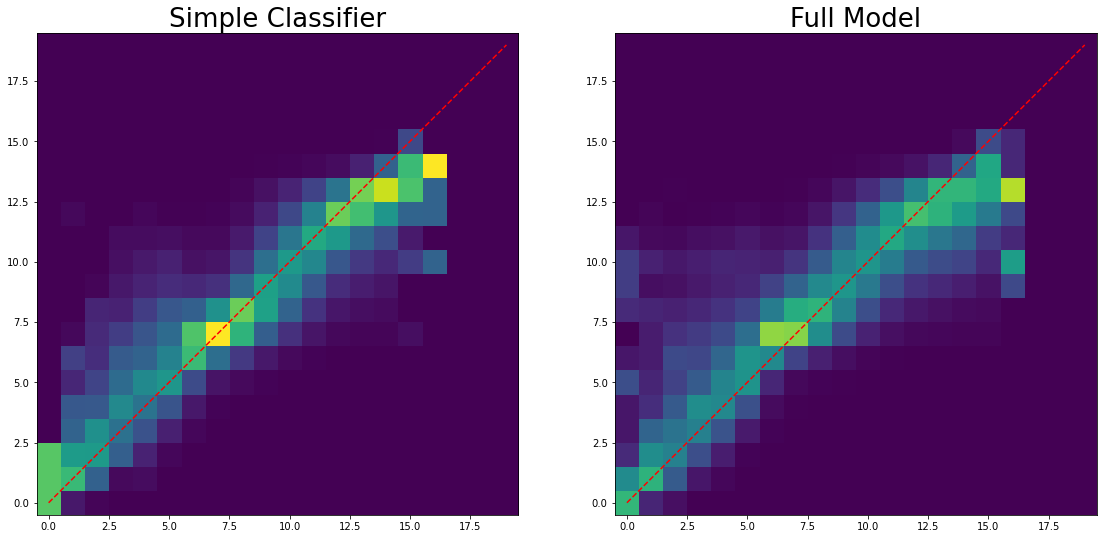

In [140]:
fig, ax = plt.subplots(1,2,figsize=(19,9))

ax[0].imshow(response_data_simple,
          origin='lower', 
             vmin=0., vmax=0.45,
          #norm=mpl.colors.LogNorm()
         )

ax[1].imshow(response_data_full,
          origin='lower',
             vmin=0., vmax=0.45,
          #norm=mpl.colors.LogNorm()
         )

ax[0].set_title('Simple Classifier', fontsize=26)
ax[1].set_title('Full Model', fontsize=26)

ax[0].plot([0,19],[0,19], ls='--', color='red')
ax[1].plot([0,19],[0,19], ls='--', color='red')

plt.show()

In [100]:
len(hist_simple[1])

21

In [149]:

hist_data_simple = hist_simple[0]
hist_axis = hist_simple[1]
axis_values = np.zeros(len(hist_simple[0]))

for i in range(len(hist_data_simple)) :
    for j in range(len(hist_data_simple[i])) :
        x = 0.5 * (hist_axis[i] + hist_axis[i+1])
        axis_values[i] = x


In [150]:
len(axis_values)

20

In [151]:
axis_values

array([0.02375, 0.07125, 0.11875, 0.16625, 0.21375, 0.26125, 0.30875,
       0.35625, 0.40375, 0.45125, 0.49875, 0.54625, 0.59375, 0.64125,
       0.68875, 0.73625, 0.78375, 0.83125, 0.87875, 0.92625])

In [102]:
hist_simple[1]

array([0.    , 0.0475, 0.095 , 0.1425, 0.19  , 0.2375, 0.285 , 0.3325,
       0.38  , 0.4275, 0.475 , 0.5225, 0.57  , 0.6175, 0.665 , 0.7125,
       0.76  , 0.8075, 0.855 , 0.9025, 0.95  ])

In [103]:
hist_simple_obs[1]

array([0.    , 0.0475, 0.095 , 0.1425, 0.19  , 0.2375, 0.285 , 0.3325,
       0.38  , 0.4275, 0.475 , 0.5225, 0.57  , 0.6175, 0.665 , 0.7125,
       0.76  , 0.8075, 0.855 , 0.9025, 0.95  ], dtype=float32)

In [104]:
hist_simple_obs[0]

array([8.00000e+00, 6.90000e+01, 1.50000e+02, 2.95000e+02, 7.20000e+02,
       2.54800e+03, 1.31600e+04, 4.61810e+04, 6.05010e+04, 6.14280e+04,
       7.52570e+04, 9.95440e+04, 1.23597e+05, 9.37270e+04, 1.16430e+04,
       8.70000e+01, 0.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00])

In [105]:
hist_simple_gen[0]

array([3.00000e+00, 1.05000e+02, 1.51000e+02, 2.79000e+02, 5.29000e+02,
       1.15300e+03, 4.11400e+03, 2.79980e+04, 5.36630e+04, 5.17690e+04,
       6.32040e+04, 8.90000e+04, 1.38364e+05, 1.39536e+05, 1.89780e+04,
       6.20000e+01, 7.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00])

In [106]:
np.sum(hist_simple[0],axis=0)

array([3.00000e+00, 1.05000e+02, 1.51000e+02, 2.79000e+02, 5.29000e+02,
       1.15300e+03, 4.11400e+03, 2.79980e+04, 5.36630e+04, 5.17690e+04,
       6.32040e+04, 8.90000e+04, 1.38364e+05, 1.39536e+05, 1.89780e+04,
       6.20000e+01, 7.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00])

In [107]:
np.sum(hist_simple[0],axis=1)

array([8.00000e+00, 6.90000e+01, 1.50000e+02, 2.95000e+02, 7.20000e+02,
       2.54800e+03, 1.31600e+04, 4.61810e+04, 6.05010e+04, 6.14280e+04,
       7.52570e+04, 9.95440e+04, 1.23597e+05, 9.37270e+04, 1.16430e+04,
       8.70000e+01, 0.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00])

In [108]:
np.sum(hist_simple_obs[0])

588915.0

In [109]:
np.sum(hist_simple_gen[0])

588915.0

In [110]:
np.sum(np.sum(hist_simple[0],axis=0))

588915.0

In [111]:
np.sum(np.sum(hist_simple[0],axis=1))

588915.0

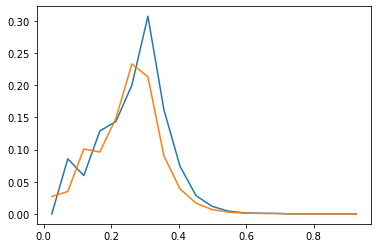

In [155]:
plt.plot(axis_values,response_data_simple[6])
plt.plot(axis_values,response_data_full[6])


In [160]:
response_data_simple_swapped = np.swapaxes( response_data_simple, 0, 1)
response_data_full_swapped = np.swapaxes( response_data_full, 0, 1)

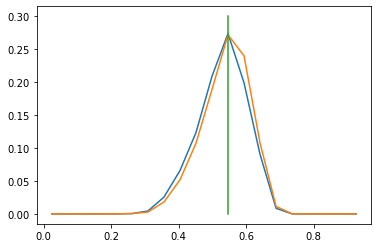

In [173]:
bin = 11
plt.plot(axis_values,response_data_simple_swapped[bin])
plt.plot(axis_values,response_data_full_swapped[bin])
plt.plot([axis_values[bin],axis_values[bin]],[0,0.3])

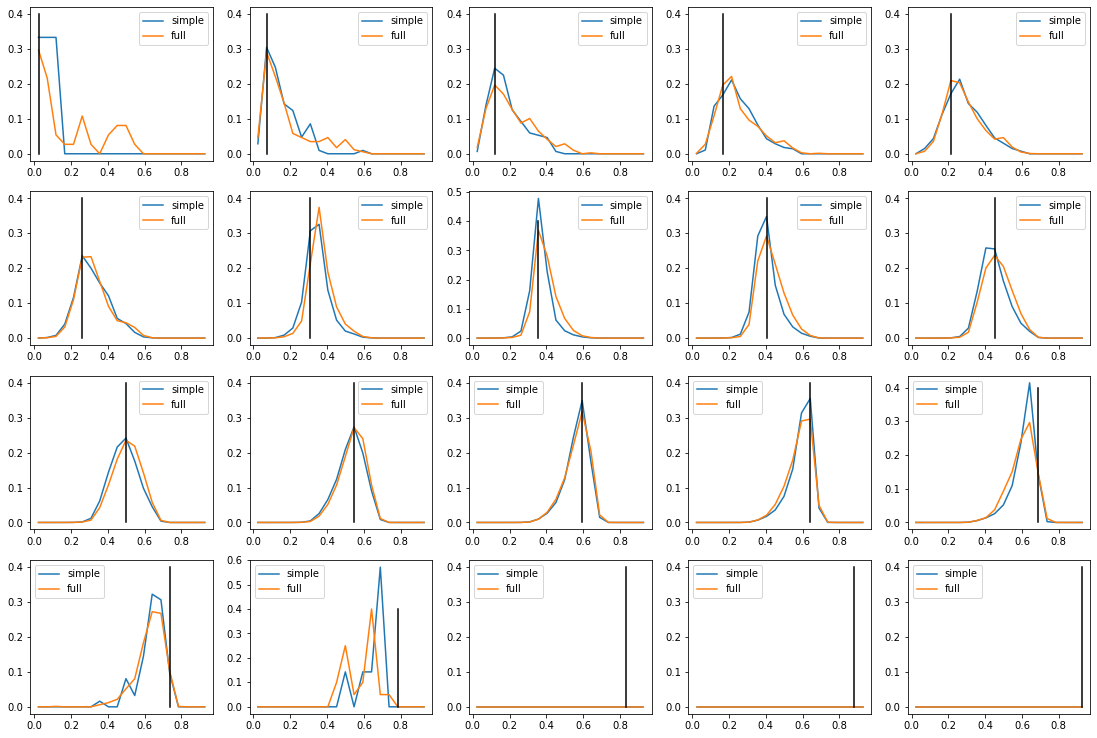

In [186]:
fig, ax = plt.subplots(4,5,figsize=(19,13))

axf = ax.flatten()

for bin in range( len(axis_values)) :
    axf[bin].plot(axis_values,response_data_simple_swapped[bin],label='simple')
    axf[bin].plot(axis_values,response_data_full_swapped[bin],label='full')
    axf[bin].plot([axis_values[bin],axis_values[bin]],[0,0.4], color='black')    
    axf[bin].legend( loc='best')
    
    

In [179]:
ax

array([[<AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>,
        <AxesSubplot:>],
       [<AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>,
        <AxesSubplot:>],
       [<AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>,
        <AxesSubplot:>],
       [<AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>,
        <AxesSubplot:>]], dtype=object)

## Sanity check :  Train a simple classifier with the same input as above (mix of particle and detector level events).

In [112]:
model_sc = Sequential()
model_sc.add(Dense(50, input_dim=9, activation='relu')) 
model_sc.add(Dense(50, activation='relu'))
model_sc.add(Dense(1, activation='sigmoid'))

opt_adam = tf.keras.optimizers.Adam(learning_rate=learning_rate_setval, amsgrad=False )

if use_weights :

    print("Training with weights.")
    
    model_sc.compile(loss='binary_crossentropy', optimizer=opt_adam, metrics=['accuracy'], 
                     weighted_metrics=['accuracy'])

else :

    model_sc.compile(loss='binary_crossentropy', optimizer=opt_adam, metrics=['accuracy'])
    

In [113]:
%%time

if run_training:
    
    if use_weights :

        hist_sc = model_sc.fit(X_gen_and_obs_train, Y_gen_and_obs_train, sample_weight = w_gen_and_obs_train,
                       validation_data=(X_gen_and_obs_test, Y_gen_and_obs_test, w_gen_and_obs_test), 
                       epochs=max_epochs, batch_size=batch_size_setval, verbose = 1, callbacks=[earlystopping] )
 
        
        
    else :
        
        hist_sc = model_sc.fit(X_gen_and_obs_train, Y_gen_and_obs_train, 
                       validation_data=(X_gen_and_obs_test, Y_gen_and_obs_test), 
                       epochs=max_epochs, batch_size=batch_size_setval, verbose = 1, callbacks=[earlystopping] )
        
        
        

CPU times: user 6 µs, sys: 1 µs, total: 7 µs
Wall time: 13.4 µs


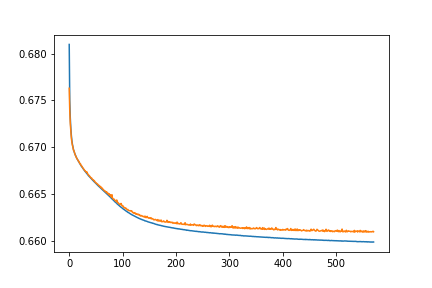

In [114]:
if run_training :
    plt.plot(hist_sc.history['loss'])
    plt.plot(hist_sc.history['val_loss'])
    plt.savefig('%s/loss-vs-epoch-standalone-classifier-gen-and-obs-inputs.pdf' % output_dir )
    plt.savefig('%s/loss-vs-epoch-standalone-classifier-gen-and-obs-inputs.png' % output_dir )

display.Image('%s/loss-vs-epoch-standalone-classifier-gen-and-obs-inputs.png' % output_dir )

In [115]:
if run_training :
    tf.keras.models.save_model( model_sc, '%s/model-standalone-classifier-gen-and-obs-inputs' % output_dir )
else :
    model_sc = tf.keras.models.load_model( '%s/model-standalone-classifier-gen-and-obs-inputs' % output_dir )

In [116]:
classifier_output_django_gen_sc = model_sc.predict( Xs_gen_d, batch_size=2048 )
classifier_output_django_obs_sc = model_sc.predict( Xs_obs_d, batch_size=2048 )
classifier_output_rapgap_gen_sc = model_sc.predict( Xs_gen_r, batch_size=2048 )
classifier_output_rapgap_obs_sc = model_sc.predict( Xs_obs_r, batch_size=2048 )

300/300 [==============================] - 0s 580us/step


Turning off weights.


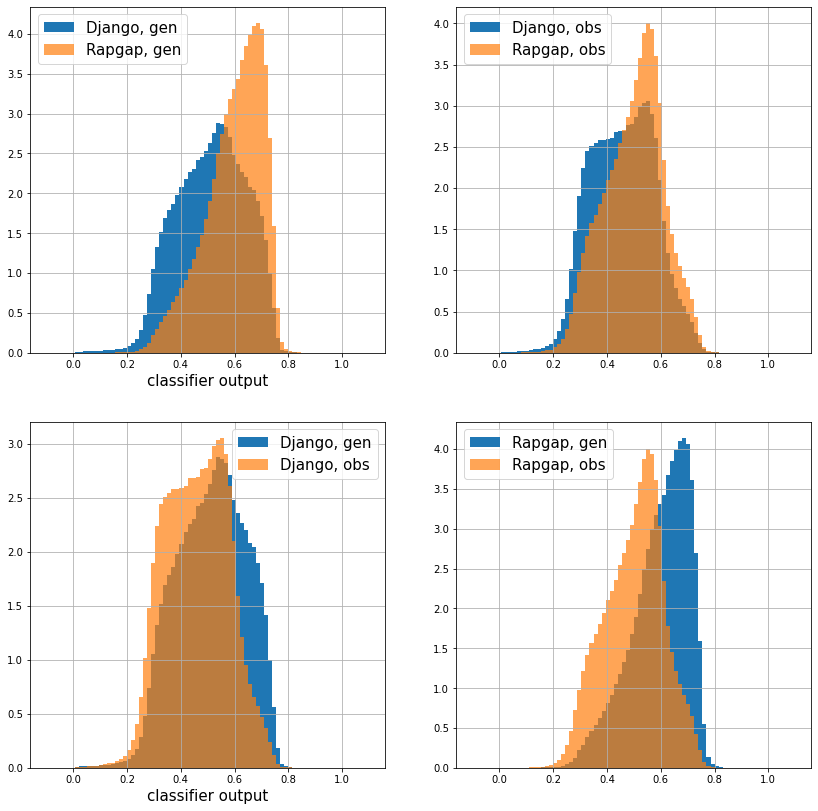

In [117]:
fig,ax = plt.subplots(2,2,figsize=(14,14))

hweights_r = w_r
hweights_d = w_d

if use_weights :
    print("Using weights.")
else :
    print("Turning off weights.")
    hweights_r.fill(1)
    hweights_d.fill(1)



ax[0][0].hist( classifier_output_django_gen_sc, weights=hweights_d,
              density=True, bins=80, range=[-0.1,1.1], label='Django, gen' )
ax[0][0].hist( classifier_output_rapgap_gen_sc, weights=hweights_r,
              density=True, bins=80, range=[-0.1,1.1], label='Rapgap, gen', alpha=0.7)
    
ax[0][1].hist( classifier_output_django_obs_sc, weights=hweights_d,
              density=True, bins=80, range=[-0.1,1.1], label='Django, obs' )
ax[0][1].hist( classifier_output_rapgap_obs_sc, weights=hweights_r,
              density=True, bins=80, range=[-0.1,1.1], label='Rapgap, obs', alpha=0.7)

ax[1][0].hist( classifier_output_django_gen_sc, weights=hweights_d,
              density=True, bins=80, range=[-0.1,1.1], label='Django, gen' )
ax[1][0].hist( classifier_output_django_obs_sc, weights=hweights_d,
              density=True, bins=80, range=[-0.1,1.1], label='Django, obs', alpha=0.7 )

ax[1][1].hist( classifier_output_rapgap_gen_sc, weights=hweights_r,
              density=True, bins=80, range=[-0.1,1.1], label='Rapgap, gen' )
ax[1][1].hist( classifier_output_rapgap_obs_sc, weights=hweights_r,
              density=True, bins=80, range=[-0.1,1.1], label='Rapgap, obs', alpha=0.7 )




ax[0][0].grid()
ax[0][1].grid()
ax[1][0].grid()
ax[1][1].grid()



hfontsize=15

ax[0][0].set_xlabel('classifier output', fontsize=hfontsize)
ax[1][0].set_xlabel('classifier output', fontsize=hfontsize)




ax[0][0].legend( loc='best', fontsize=hfontsize)
ax[1][0].legend( loc='best', fontsize=hfontsize)
ax[0][1].legend( loc='best', fontsize=hfontsize)
ax[1][1].legend( loc='best', fontsize=hfontsize)


plt.show()

## Try and set up a classifier that takes a single input, which is the output of the Django vs Rapgap classifier

In [118]:
model_adv_standalone = Sequential()
model_adv_standalone.add(Dense(50, input_dim=1, activation='relu')) 
model_adv_standalone.add(Dense(50, activation='relu'))
model_adv_standalone.add(Dense(50, activation='relu'))
model_adv_standalone.add(Dense(50, activation='relu'))
model_adv_standalone.add(Dense(50, activation='relu'))
model_adv_standalone.add(Dense(1, activation='sigmoid'))

opt_adam = tf.keras.optimizers.Adam(learning_rate=learning_rate_setval, amsgrad=False )

if use_weights :

    model_adv_standalone.compile(loss='binary_crossentropy', optimizer=opt_adam, metrics=['accuracy'],
                                weighted_metrics=['accuracy'])
    
else :
    
    model_adv_standalone.compile(loss='binary_crossentropy', optimizer=opt_adam, metrics=['accuracy'])
    

In [119]:
X_adv_standalone_train = model_sc.predict( X_gen_and_obs_train, batch_size=2048 )
X_adv_standalone_test = model_sc.predict( X_gen_and_obs_test, batch_size=2048 )

576/576 [==============================] - 0s 615us/step


In [120]:
%%time

if run_training :
    
    if use_weights :
        
        hist_adv_standalone = model_adv_standalone.fit(X_adv_standalone_train, Z_gen_and_obs_train,
                                    sample_weight=w_gen_and_obs_train,
                                    validation_data=(X_adv_standalone_test, Z_gen_and_obs_test, w_gen_and_obs_test),
                                    epochs=max_epochs, batch_size=batch_size_setval,
                                    verbose = 1, callbacks=[earlystopping] )
        
    else :
        
        hist_adv_standalone = model_adv_standalone.fit(X_adv_standalone_train, Z_gen_and_obs_train, 
                                               validation_data=(X_adv_standalone_test, Z_gen_and_obs_test),
                                               epochs=max_epochs, batch_size=batch_size_setval,
                                               verbose = 1, callbacks=[earlystopping] )

CPU times: user 6 µs, sys: 1 µs, total: 7 µs
Wall time: 12.6 µs


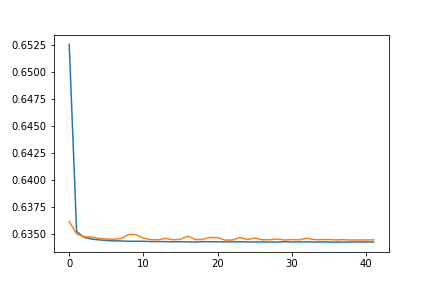

In [121]:
if run_training :
    plt.plot(hist_adv_standalone.history['loss'])
    plt.plot(hist_adv_standalone.history['val_loss'])
    plt.savefig('%s/loss-vs-epoch-standalone-adversary-gen-and-obs-inputs-no-labels.pdf' % output_dir )
    plt.savefig('%s/loss-vs-epoch-standalone-adversary-gen-and-obs-inputs-no-labels.png' % output_dir )

display.Image('%s/loss-vs-epoch-standalone-adversary-gen-and-obs-inputs-no-labels.png' % output_dir )

In [122]:
if run_training :
    tf.keras.models.save_model( model_adv_standalone, 
                           '%s/model-standalone-adversary-gen-and-obs-inputs-no-labels' % output_dir )
else :
    model_adv_standalone = tf.keras.models.load_model(
                           '%s/model-standalone-adversary-gen-and-obs-inputs-no-labels' % output_dir )    

In [123]:
adv_pred = model_adv_standalone.predict( X_adv_standalone_test, batch_size=2048 )

576/576 [==============================] - 0s 699us/step


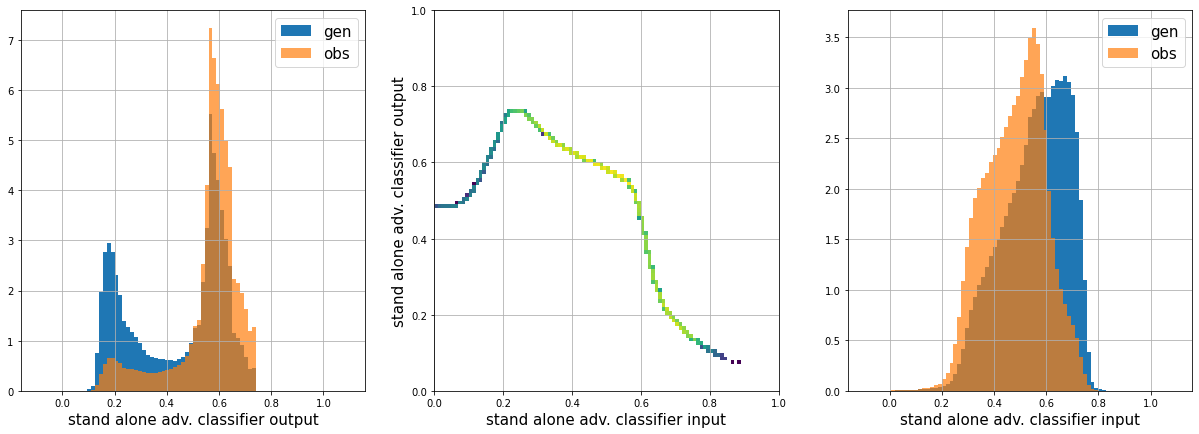

In [124]:
fig,ax = plt.subplots(1,3,figsize=(21,7))


hweights = w_gen_and_obs_test
    
if use_weights :
    print("Using weights.")
else :
    hweights.fill( 1. )
    
    

ax[0].hist( adv_pred[Z_gen_and_obs_test==0], weights=hweights[Z_gen_and_obs_test==0],
           density=True, bins=80, range=[-0.1,1.1], label='gen' )
ax[0].hist( adv_pred[Z_gen_and_obs_test==1], weights=hweights[Z_gen_and_obs_test==1],
           density=True, bins=80, range=[-0.1,1.1], label='obs', alpha=0.7)

ax[1].hist2d( X_adv_standalone_test[:,0], adv_pred[:,0], weights=hweights[:,0],
             bins=100, range=([0,1],[0,1]), norm=mpl.colors.LogNorm()  )

ax[2].hist( X_adv_standalone_test[Z_gen_and_obs_test==0], weights=hweights[Z_gen_and_obs_test==0],
           bins=80, range=[-0.1,1.1], label='gen', density=True )
ax[2].hist( X_adv_standalone_test[Z_gen_and_obs_test==1], weights=hweights[Z_gen_and_obs_test==1],
           bins=80, range=[-0.1,1.1], label='obs', density=True, alpha=0.7 )

ax[0].grid()
ax[1].grid()
ax[2].grid()



hfontsize=15

ax[0].set_xlabel('stand alone adv. classifier output', fontsize=hfontsize)

ax[1].set_xlabel('stand alone adv. classifier input', fontsize=hfontsize)
ax[1].set_ylabel('stand alone adv. classifier output', fontsize=hfontsize)

ax[2].set_xlabel('stand alone adv. classifier input', fontsize=hfontsize)


ax[0].legend( loc='best', fontsize=hfontsize)
ax[2].legend( loc='best', fontsize=hfontsize)


plt.show()

## Now try training the adversary part in the same way, providing the first NN output and the Y labels for the first NN as inputs to the adversary network

In [125]:
np.shape(X_gen_and_obs_train)

(1177830, 9)

In [126]:
X_adv_standalone2_train = np.concatenate([X_adv_standalone_train, Y_gen_and_obs_train],axis=1 )
X_adv_standalone2_test = np.concatenate([X_adv_standalone_test, Y_gen_and_obs_test],axis=1 )

In [127]:
X_adv_standalone2_train

array([[0.62896138, 0.        ],
       [0.4054732 , 1.        ],
       [0.37180084, 0.        ],
       ...,
       [0.28547171, 0.        ],
       [0.46482328, 1.        ],
       [0.61632341, 1.        ]])

In [128]:
for i in range(20):
    print("  %.4f  %.1f" % (X_adv_standalone2_train[i,0], X_adv_standalone2_train[i,1]))

  0.6290  0.0
  0.4055  1.0
  0.3718  0.0
  0.6780  1.0
  0.3617  0.0
  0.4714  0.0
  0.6672  1.0
  0.3273  1.0
  0.6705  1.0
  0.6433  0.0
  0.0711  0.0
  0.5173  1.0
  0.3605  0.0
  0.4370  0.0
  0.5543  1.0
  0.4533  0.0
  0.5139  1.0
  0.3340  0.0
  0.6427  1.0
  0.3229  1.0


In [129]:
model_adv_standalone2 = Sequential()
model_adv_standalone2.add(Dense(50, input_dim=2, activation='relu')) 
model_adv_standalone2.add(Dense(50, activation='relu'))
model_adv_standalone2.add(Dense(50, activation='relu'))
model_adv_standalone2.add(Dense(50, activation='relu'))
model_adv_standalone2.add(Dense(50, activation='relu'))
model_adv_standalone2.add(Dense(1, activation='sigmoid'))

opt_adam = tf.keras.optimizers.Adam(learning_rate=learning_rate_setval, amsgrad=False )


if use_weights :
    
    model_adv_standalone2.compile(loss='binary_crossentropy', optimizer=opt_adam, metrics=['accuracy'],
                                 weighted_metrics=['accuracy'])

else :
    
    model_adv_standalone2.compile(loss='binary_crossentropy', optimizer=opt_adam, metrics=['accuracy'])

In [130]:
%%time

if run_training :
    
    if use_weights :

        hist_adv_standalone2 = model_adv_standalone2.fit(X_adv_standalone2_train, Z_gen_and_obs_train,
                                        sample_weight=w_gen_and_obs_train,
                                        validation_data=(X_adv_standalone2_test, Z_gen_and_obs_test, w_gen_and_obs_test),
                                        epochs=max_epochs, batch_size=batch_size_setval,
                                        verbose = 1, callbacks=[earlystopping] )
        
    else :
        
        hist_adv_standalone2 = model_adv_standalone2.fit(X_adv_standalone2_train, Z_gen_and_obs_train, 
                                               validation_data=(X_adv_standalone2_test, Z_gen_and_obs_test),
                                               epochs=max_epochs, batch_size=batch_size_setval,
                                               verbose = 1, callbacks=[earlystopping] )


CPU times: user 6 µs, sys: 1 µs, total: 7 µs
Wall time: 13.4 µs


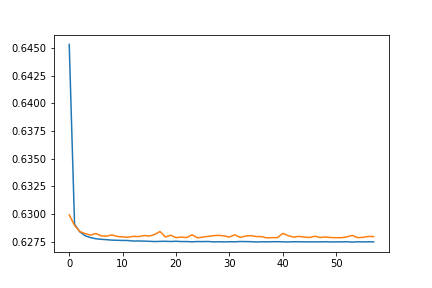

In [131]:
if run_training :
    plt.plot(hist_adv_standalone2.history['loss'])
    plt.plot(hist_adv_standalone2.history['val_loss'])
    plt.savefig('%s/loss-vs-epoch-standalone-adversary-gen-and-obs-inputs-with-labels.pdf' % output_dir )
    plt.savefig('%s/loss-vs-epoch-standalone-adversary-gen-and-obs-inputs-with-labels.png' % output_dir )

display.Image('%s/loss-vs-epoch-standalone-adversary-gen-and-obs-inputs-with-labels.png' % output_dir )

In [132]:
if run_training :
    tf.keras.models.save_model( model_adv_standalone2, 
                           '%s/model-standalone-adversary-gen-and-obs-inputs-with-labels' % output_dir )
else :
    model_adv_standalone2 = tf.keras.models.load_model(
                           '%s/model-standalone-adversary-gen-and-obs-inputs-with-labels' % output_dir )

In [133]:
adv2_pred = model_adv_standalone2.predict( X_adv_standalone2_test, batch_size=2048 )

576/576 [==============================] - 0s 695us/step


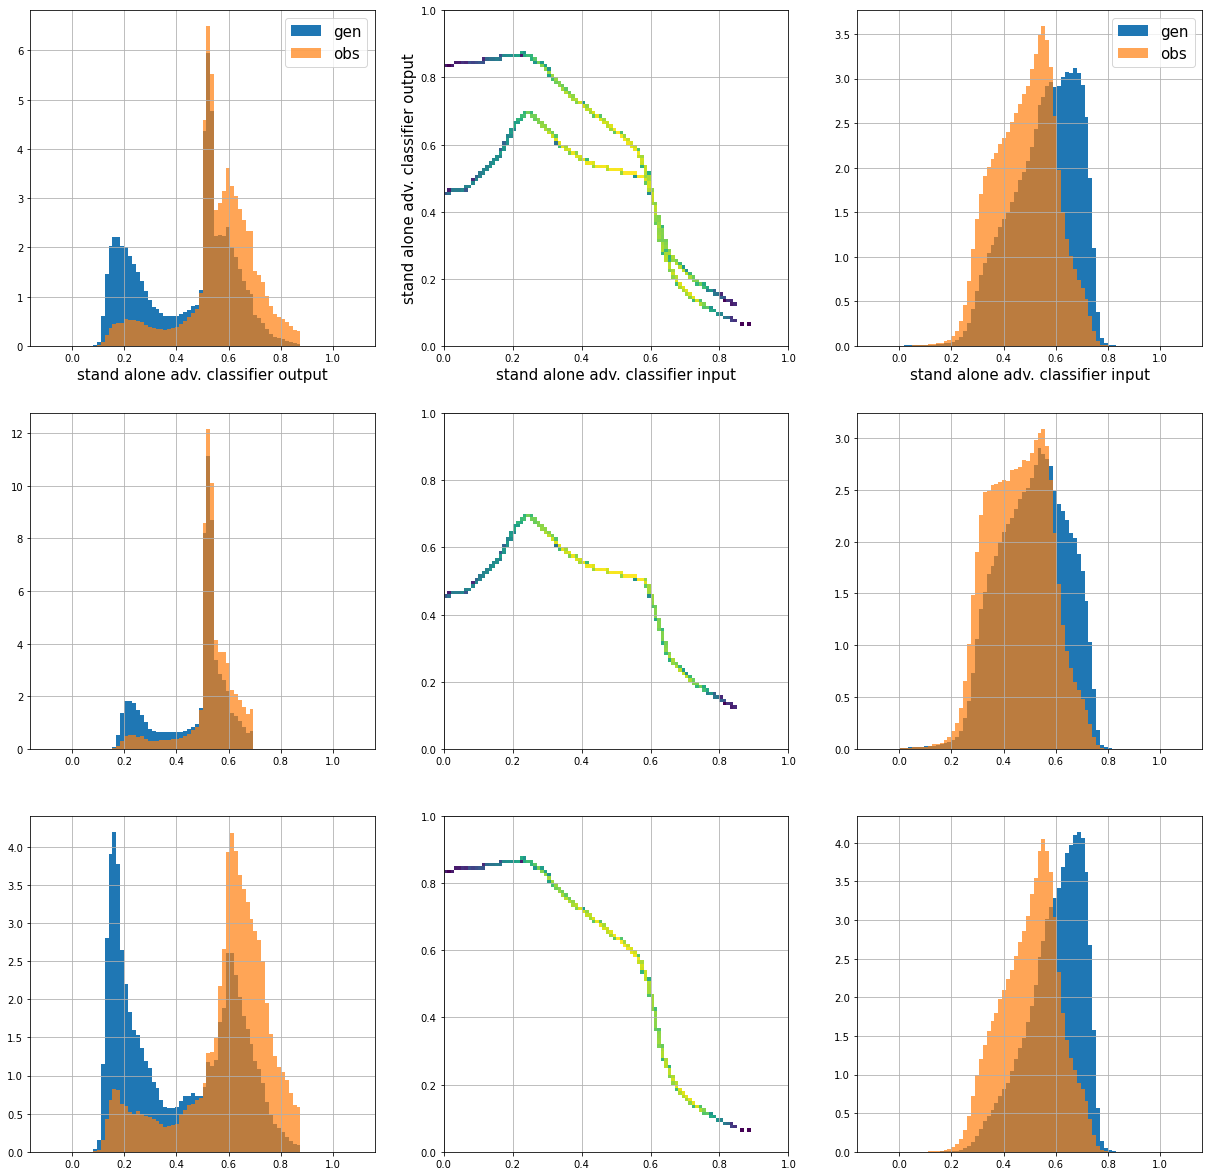

In [134]:
fig,ax = plt.subplots(3,3,figsize=(21,21))

hweights = w_gen_and_obs_test
    
if use_weights :
    print("Using weights.")
else :
    hweights.fill( 1. )
  


#-----------

ax[0][0].hist( adv2_pred[Z_gen_and_obs_test==0], weights=hweights[Z_gen_and_obs_test==0],
              density=True, bins=80, range=[-0.1,1.1], label='gen' )
ax[0][0].hist( adv2_pred[Z_gen_and_obs_test==1], weights=hweights[Z_gen_and_obs_test==1],
              density=True, bins=80, range=[-0.1,1.1], label='obs', alpha=0.7)

ax[0][1].hist2d( X_adv_standalone2_test[:,0], adv2_pred[:,0], weights=hweights[:,0],
                bins=100, range=([0,1],[0,1]), norm=mpl.colors.LogNorm()  )

ax[0][2].hist( X_adv_standalone2_test[Z_gen_and_obs_test==0][:,0], weights=hweights[Z_gen_and_obs_test==0][:,0],
              bins=80, range=[-0.1,1.1], label='gen', density=True )
ax[0][2].hist( X_adv_standalone2_test[Z_gen_and_obs_test==1][:,0], weights=hweights[Z_gen_and_obs_test==1][:,0],
              bins=80, range=[-0.1,1.1], label='obs', density=True, alpha=0.7 )

ax[0][0].grid()
ax[0][1].grid()
ax[0][2].grid()

#-----------


ax[1][0].hist( adv2_pred[Z_gen_and_obs_test==0][X_adv_standalone2_test[Z_gen_and_obs_test==0,1]==0], 
              weights=hweights[Z_gen_and_obs_test==0][X_adv_standalone2_test[Z_gen_and_obs_test==0,1]==0],
              density=True, bins=80, range=[-0.1,1.1], label='gen' )
ax[1][0].hist( adv2_pred[Z_gen_and_obs_test==1][X_adv_standalone2_test[Z_gen_and_obs_test==1,1]==0],
              weights=hweights[Z_gen_and_obs_test==1][X_adv_standalone2_test[Z_gen_and_obs_test==1,1]==0],
              density=True, bins=80, range=[-0.1,1.1], label='obs', alpha=0.7)

ax[1][1].hist2d( X_adv_standalone2_test[X_adv_standalone2_test[:,1]==0,0], 
                adv2_pred[X_adv_standalone2_test[:,1]==0,0], 
                weights=hweights[X_adv_standalone2_test[:,1]==0,0],
                bins=100, range=([0,1],[0,1]), norm=mpl.colors.LogNorm()  )

ax[1][2].hist( X_adv_standalone2_test[Z_gen_and_obs_test==0][X_adv_standalone2_test[Z_gen_and_obs_test==0,1]==0][:,0], 
              weights=hweights[Z_gen_and_obs_test==0][X_adv_standalone2_test[Z_gen_and_obs_test==0,1]==0][:,0], 
              bins=80, range=[-0.1,1.1], label='gen', density=True )
ax[1][2].hist( X_adv_standalone2_test[Z_gen_and_obs_test==1][X_adv_standalone2_test[Z_gen_and_obs_test==1,1]==0][:,0], 
              weights=hweights[Z_gen_and_obs_test==1][X_adv_standalone2_test[Z_gen_and_obs_test==1,1]==0][:,0], 
              bins=80, range=[-0.1,1.1], label='obs', density=True, alpha=0.7 )

ax[1][0].grid()
ax[1][1].grid()
ax[1][2].grid()

#-----------

ax[2][0].hist( adv2_pred[Z_gen_and_obs_test==0][X_adv_standalone2_test[Z_gen_and_obs_test==0,1]==1], 
              weights=hweights[Z_gen_and_obs_test==0][X_adv_standalone2_test[Z_gen_and_obs_test==0,1]==1],
              density=True, bins=80, range=[-0.1,1.1], label='gen' )
ax[2][0].hist( adv2_pred[Z_gen_and_obs_test==1][X_adv_standalone2_test[Z_gen_and_obs_test==1,1]==1], 
              weights=hweights[Z_gen_and_obs_test==1][X_adv_standalone2_test[Z_gen_and_obs_test==1,1]==1],
              density=True, bins=80, range=[-0.1,1.1], label='obs', alpha=0.7)


ax[2][1].hist2d( X_adv_standalone2_test[X_adv_standalone2_test[:,1]==1,0], adv2_pred[X_adv_standalone2_test[:,1]==1,0], 
                weights=hweights[X_adv_standalone2_test[:,1]==1,0], 
                bins=100, range=([0,1],[0,1]), norm=mpl.colors.LogNorm()  )

ax[2][2].hist( X_adv_standalone2_test[Z_gen_and_obs_test==0][X_adv_standalone2_test[Z_gen_and_obs_test==0,1]==1][:,0], 
              weights=hweights[Z_gen_and_obs_test==0][X_adv_standalone2_test[Z_gen_and_obs_test==0,1]==1][:,0],
              bins=80, range=[-0.1,1.1], label='gen', density=True )
ax[2][2].hist( X_adv_standalone2_test[Z_gen_and_obs_test==1][X_adv_standalone2_test[Z_gen_and_obs_test==1,1]==1][:,0], 
              weights=hweights[Z_gen_and_obs_test==1][X_adv_standalone2_test[Z_gen_and_obs_test==1,1]==1][:,0],
              bins=80, range=[-0.1,1.1], label='obs', density=True, alpha=0.7 )


ax[2][0].grid()
ax[2][1].grid()
ax[2][2].grid()


#-----------




hfontsize=15

ax[0][0].set_xlabel('stand alone adv. classifier output', fontsize=hfontsize)

ax[0][1].set_xlabel('stand alone adv. classifier input', fontsize=hfontsize)
ax[0][1].set_ylabel('stand alone adv. classifier output', fontsize=hfontsize)

ax[0][2].set_xlabel('stand alone adv. classifier input', fontsize=hfontsize)


ax[0][0].legend( loc='best', fontsize=hfontsize)
ax[0][2].legend( loc='best', fontsize=hfontsize)


plt.show()